In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

# Analyze robustness test

In [13]:
class RobustTest:

    '''
    analyze data from robustness test

    methods
    categorize_value : categorize genes based on their fdr values
    plotcat : generate heatmap with categorized data
    heatmap : import data from given repository & iterate plotcat 
    sort_val : calculate tpr, fpr, common number of genes under selection
    plot : plot the values from sort_val
    '''

    def __init__(self,
                 original,
                 species,
                 directory,
                 outpath
                 ):
        
        '''
        Arguments
        oritinal(DataFrame) : original ou result
        species(DataFrame) : containing information of deleted species at each datasets
        directory(str) : ou result dataset directory, each dataset should contain qvalues column and gene_names for rownames
        '''

        # original data
        self.original = original.sort_values(by="qvalues")
        self.original_idx = self.original["gene_name"]

        self.species = species
        self.directory = directory
        self.outpath = outpath
        self.db = {}


    def categorize_value(self, value):
        ## categorize fdr value 
        if value <= 0.05:
            return 'selection'
        elif value > 0.05:
            return 'drift'
        else:
            return 'None'
        
    
    def plotcat(self, cat, title):
        # Define a mapping dictionary for categorical to numerical values
        cat_mapping = {
            "selection": 0,
            "None": 1,
            "drift": 2
        }

        # Convert categorical values to numerical values
        numerical_df = cat.replace(cat_mapping)

        # discrete colormap (n samples from a given cmap)
        colors = ["#FFC1C1","#D3D3D3", "#C1C1FF"]
        cmap = sns.color_palette(colors, as_cmap=True)
        ax = sns.heatmap(numerical_df, cmap=cmap) 

        # Get the colorbar
        colorbar = ax.collections[0].colorbar

        # Set the tick positions and labels
        tick_positions = [1/3, 1, 5/3]
        tick_labels = ["stabilizing selection","None", "neutral evolution"]

        # Set the tick positions and labels on the colorbar
        colorbar.set_ticks(tick_positions)
        colorbar.set_ticklabels(tick_labels)  

        directory = self.outpath+title+".png"
        #print(directory)
        plt.savefig(directory)
        plt.show()
    

    def heatmap(self):
        # import data from directory & iterate plotcat
        for s, sim in enumerate(self.species.columns):
            directory = f"{self.directory}{s+1}_sim/"
            df = {}
            for i in self.species[sim]:
                df[i] = pd.read_csv(directory+i+".txt",delimiter="\t", index_col = 0)
                df[i] = df[i].reindex(self.original_idx)

            cat = {}
            cat["original"] = self.original['qvalues'].apply(self.categorize_value).tolist()
            for i in self.species[sim]:
                cat[i] = df[i]['qvalues'].apply(self.categorize_value).tolist()
            cat = pd.DataFrame(cat)
            cat.index = self.original_idx
            self.db[s] = cat
            
            self.plotcat(cat = cat, title = f"cat_{sim}")
        return self.db


    def sort_val(self):
        # generate dictionaries : df, FPR, TPR, TP, tt, ff

        df = {}   # number of genes under selection
        FPR = {}  # FP / (FP + TN)
        TPR = {}  # TP / (TP _ FN)
        TP = {}   # TP 
        tt = {}   # number of genes under selection
        ff = {}   # number of genes under drift

        true = self.db[0][self.db[0]["original"] == "selection"].index.tolist()
        false = self.db[0][self.db[0]["original"] == "drift"].index.tolist()

        for i in range(1, len(self.db[0].columns)):
            df[17-i] = []
            FPR[17-i] = []
            TPR[17-i] = []
            TP[17-i] = []
            tt[17-i] = []
            ff[17-i] = []

            for j in self.db.keys():
                # number of genes under selection in ith dataset in each db keys
                df[17-i].append(np.sum(self.db[j].iloc[:,i] == "selection"))

                positive = self.db[j][self.db[j].iloc[:,i]=="selection"].index.tolist()
                negative = self.db[j][self.db[j].iloc[:,i]=="drift"].index.tolist()
                tt[17-i].append(len(positive))
                ff[17-i].append(len(negative))

                # fpr
                if len(negative) == 0:
                    FPR[17-i].append(None)
                else:
                    fp = set(false) & set(positive)
                    tn = set(true) & set(negative)
                    FPR[17-i].append(len(fp) / (len(fp)+len(tn)))

                # tpr
                if len(positive) == 0:
                    TPR[17-i].append(0)
                    TP[17-i].append(0)
                else:
                    tp = set(true) & set(positive)
                    fn = set(false) & set(negative)
                    TPR[17-i].append(len(tp) / (len(tp)+len(fn)))
                    TP[17-i].append(len(tp))

        return df, FPR, TPR, TP, tt, ff
    

    def plot(self) : 

        # get values
        df, FPR, TPR, TP, tt, ff = self.sort_val()

        ## number of genes under stabilizing selection ------------------------------------------------------------
        num = len(self.db[0][self.db[0]["original"] == "selection"].index.tolist())
        plt.boxplot(df.values(), labels=df.keys())
        plt.xticks(range(1, len(df.keys()) + 1), df.keys(), rotation=90)
        plt.xlabel('number of species')
        plt.ylabel('number of genes with low fdr value')
        plt.title('Robustness test, '+f', {num} genes in whole species')
        horizontal_line_value = num
        plt.axhline(y = num, color='b', linestyle='--')
        directory = self.outpath+"Robustness_test.png"
        plt.savefig(directory)
        plt.show()

        ## FPR -------------------------------------------------------------------------------------------------
        mean_fpr = []
        std_fpr = []

        for i in FPR.keys():
            fpr = pd.Series(FPR[i])
            mean_fpr.append(fpr.mean(skipna=True))
            std_fpr.append(fpr.std(skipna=True))

        x = np.arange(len(FPR.keys()))
        plt.errorbar(x, mean_fpr, yerr=std_fpr, fmt='o')
        plt.xticks(range(len(df.keys())), df.keys(), rotation=90)
        plt.xlabel("number of species")
        plt.ylabel('Mean FPR')
        plt.title('Robustness test, fpr')
        directory = self.outpath+"FPR.png"
        plt.savefig(directory)
        plt.show()

        ## TPR -------------------------------------------------------------------------------------------------
        mean_tpr = []
        std_tpr = []

        for i in TPR.keys():
            tpr = pd.Series(TPR[i])
            mean_tpr.append(tpr.mean(skipna=True))
            std_tpr.append(tpr.std(skipna=True))

        plt.errorbar(x, mean_tpr, yerr=std_tpr, fmt='o')
        plt.xticks(range(len(df.keys())), df.keys(), rotation=90)
        plt.xlabel("number of species")
        plt.ylabel('Mean TPR')
        plt.title('Robustness test, TPR')
        directory = self.outpath+"TPR.png"
        plt.savefig(directory)
        plt.show()

        ## common genes ----------------------------------------------------------------------------------------
        mean = []
        std = []

        for i in TP.keys():
            tp = pd.Series(TP[i])
            mean.append(tp.mean(skipna=False))
            std.append(tp.std(skipna=False))

        plt.errorbar(x, mean, yerr=std, fmt='o')
        plt.xticks(range(len(df.keys())), df.keys(), rotation=90)
        plt.xlabel("number of species")
        plt.ylabel('Mean ratio')
        plt.title('Robustness test, common genes, TP/true')
        directory = self.outpath+"TP.png"
        plt.savefig(directory)
        plt.show()

        ## ratio of categories --------------------------------------------------------------------------------
        feature1 = [np.mean(value) for key, value in tt.items()]
        feature2 = [np.mean(value) for key, value in ff.items()]

        plt.bar(x, feature1, label='stabilizing selection')
        plt.bar(x, feature2, bottom=feature1, label='neutral drift')
        plt.xticks(range(len(df.keys())), df.keys(), rotation=90)
        plt.xlabel("number of species")
        plt.ylabel('mean number of genes')
        plt.title('Robustness test, proportion of genes')
        directory = self.outpath+"ratio.png"
        plt.savefig(directory)
        plt.legend()
        plt.show()

# input data

In [16]:
# original data
original = pd.read_csv("/Users/yunseong-eun/Desktop/simulation/R (1)/result/sim2_result.txt", delimiter = "\t")
original

gene_name   qvalues        sigmas     alphas     thetas          var   
1             1  0.002650      1.757635  20.770118   0.624089     0.042312  \
2             2  0.000165      4.304923  55.989181   1.043440     0.038444   
3             3  0.000355      7.121147  93.056405   1.267513     0.038263   
4             4  0.008520  41991.249757  20.853764  21.036329  1006.802644   
5             5  0.068780      3.118585   8.538158  -1.378096     0.182626   
...         ...       ...           ...        ...        ...          ...   
996         996  0.057263   1271.352750   7.649263  30.900466    83.102960   
997         997  1.000000    279.694628   1.722339  12.595031    81.196148   
998         998  1.000000   1079.394066   2.144517  12.771899   251.663723   
999         999  0.577773    899.340372   4.373662   4.773810   102.813205   
1000       1000  0.551100   1021.114517   5.051283  13.376640   101.074772   

       brownSigmas  
1         0.688185  
2         1.087181  
3         1.015807  
4     31510.984105  
5         1.547421  
...            ...  
996     658.408751  
997     215.268861  
998     792.835397  
999     561.267949  
1000    663.275519  

[1000 rows x 7 columns]

In [5]:
# species matrix
species = pd.read_csv("/Users/yunseong-eun/Desktop/simulation/R (1)/robustness1/species.txt", delimiter = "\t")
#species = species.drop("Unnamed: 0", axis=1)
species

sp         sp.1         sp.2         sp.3       sp.4        sp.5   
1        ferret       bonobo       ferret  musMusculus      chimp         dog  \
2         human      opossum      gorilla     marmoset        rat      bonobo   
3        bonobo          cow          rat      gorilla      human       human   
4       gorilla       rhesus   musSpretus   musSpretus     rhesus      rhesus   
5   musMusculus    armadillo          dog          rat        dog   orangutan   
6      marmoset   musSpretus       bonobo       rhesus        cow   musCaroli   
7         chimp       rabbit       rhesus       rabbit     rabbit     opossum   
8        rabbit     marmoset      opossum    musCaroli  armadillo     gorilla   
9     musCaroli          dog        human    orangutan    opossum    marmoset   
10   musSpretus    orangutan    armadillo          dog  orangutan      rabbit   
11    orangutan  musMusculus       rabbit       bonobo     bonobo   armadillo   
12    armadillo       ferret  musMusculus       ferret   marmoset         cow   
13          rat          rat    orangutan    armadillo  musCaroli      ferret   
14          cow        chimp        chimp        human     ferret  musSpretus   

           sp.6        sp.7         sp.8         sp.9  
1     musCaroli      rabbit    orangutan     marmoset  
2       opossum     gorilla    armadillo  musMusculus  
3     armadillo   armadillo  musMusculus        human  
4         chimp       human       ferret    musCaroli  
5        bonobo  musSpretus          dog    armadillo  
6   musMusculus         rat       rhesus      gorilla  
7           rat    marmoset   musSpretus       rhesus  
8      marmoset     opossum      opossum       rabbit  
9           dog   orangutan       bonobo       bonobo  
10      gorilla       chimp       rabbit        chimp  
11       ferret         cow        human      opossum  
12          cow      ferret      gorilla    orangutan  
13       rhesus      bonobo    musCaroli          rat  
14   musSpretus      rhesus          rat          cow

In [17]:
directory = "/Users/yunseong-eun/Desktop/simulation/R (1)/robustness1/2/"

In [18]:
outpath = "/Users/yunseong-eun/Desktop/simulation/R (1)/robustness_result/2/"

# test

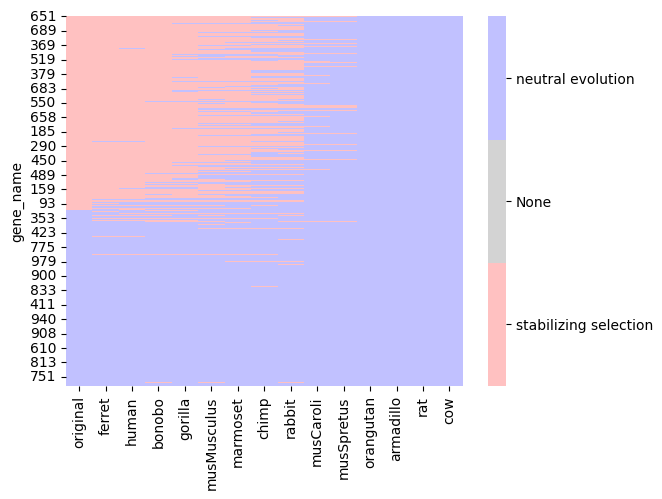

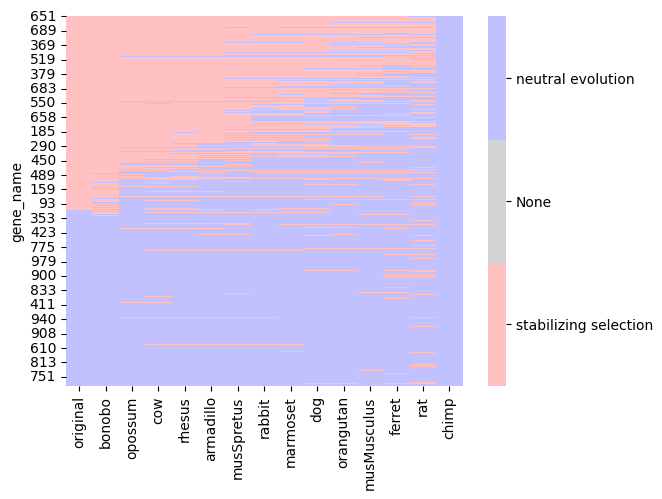

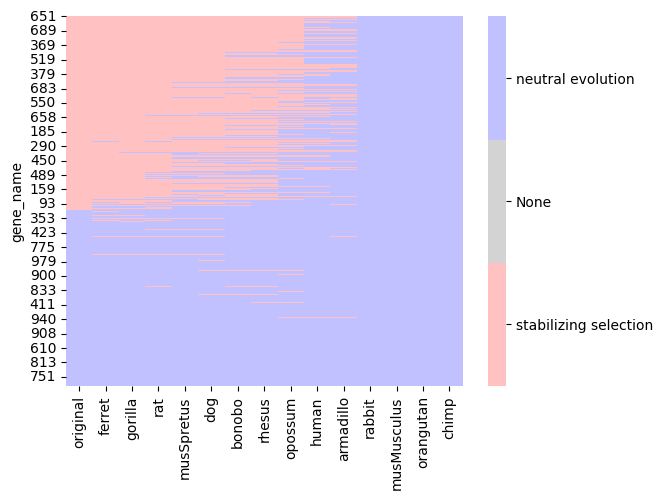

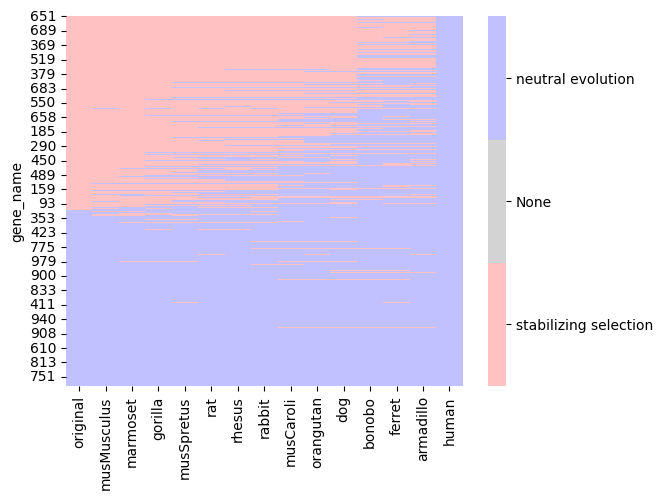

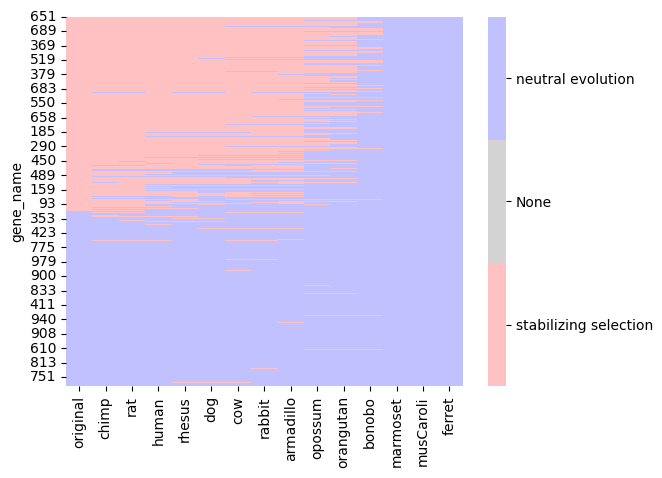

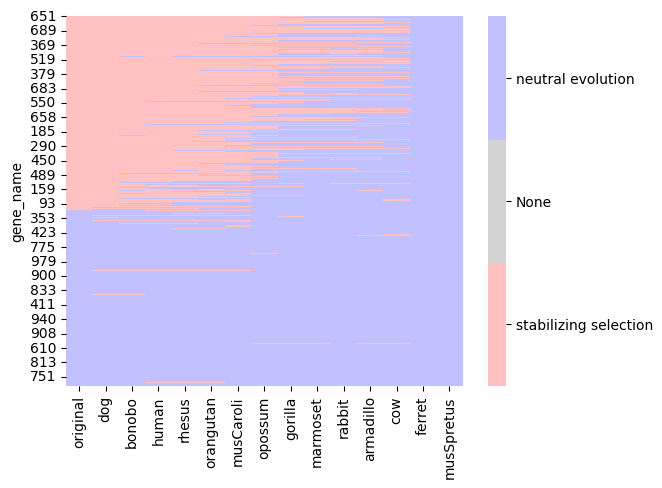

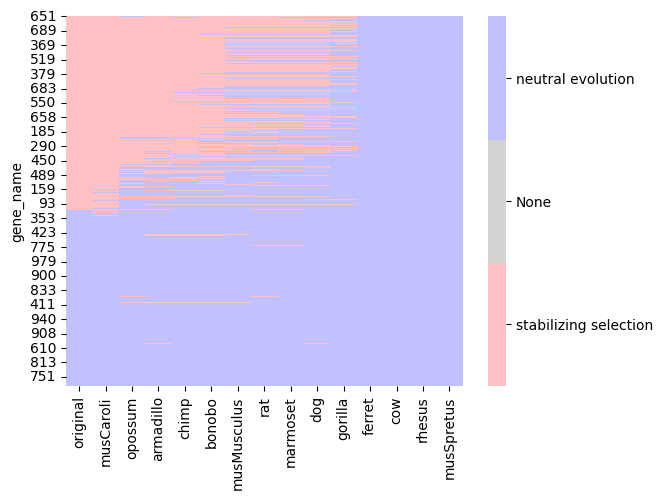

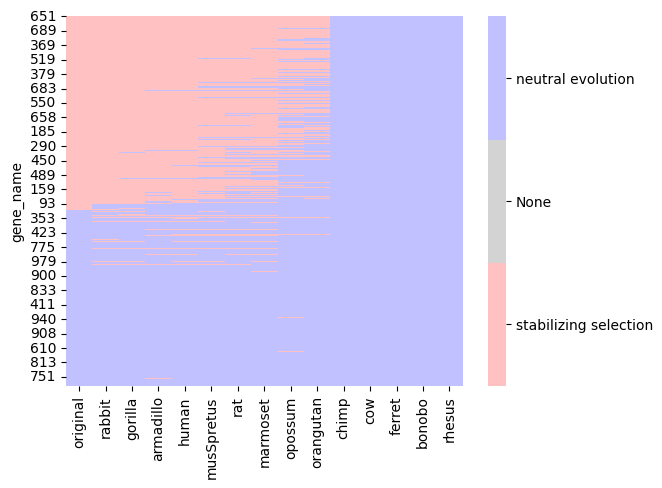

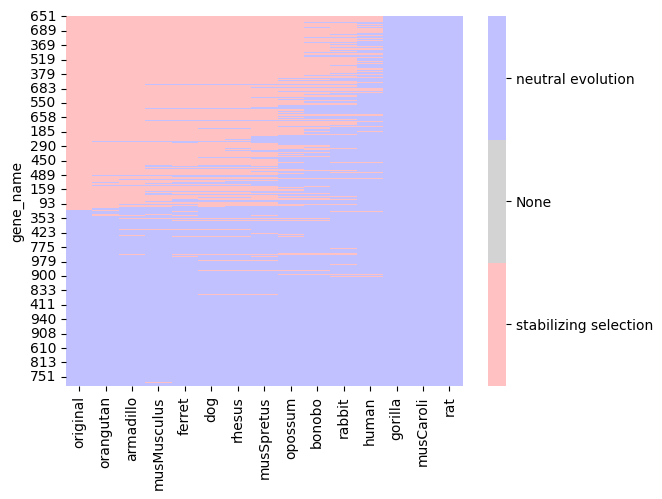

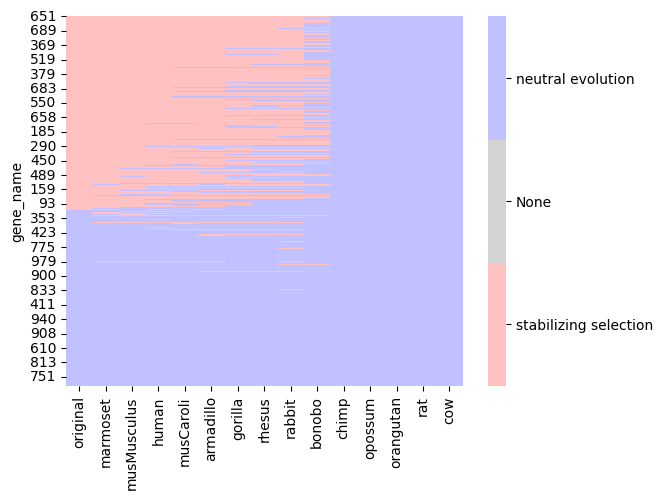

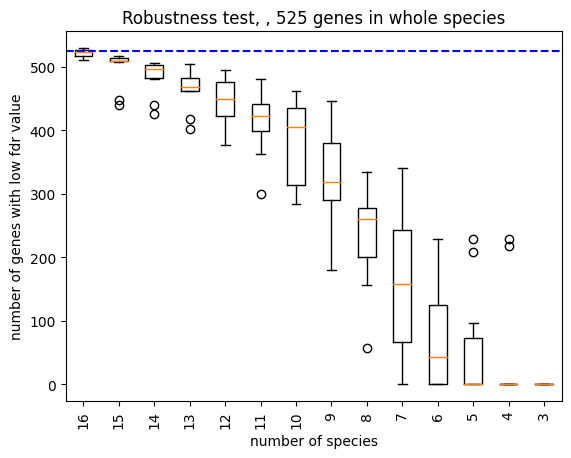

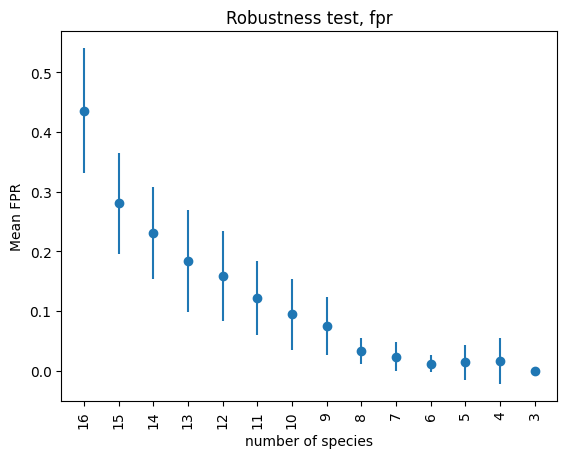

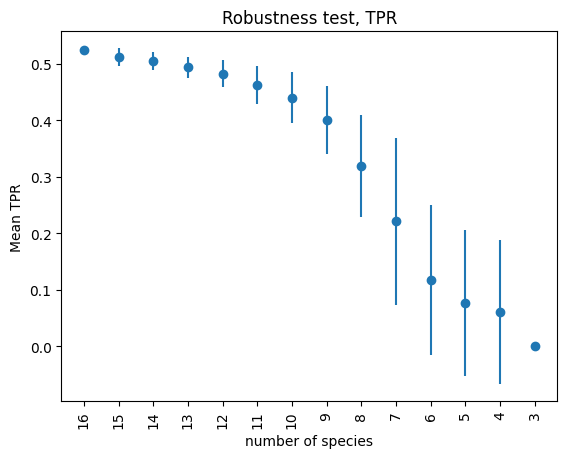

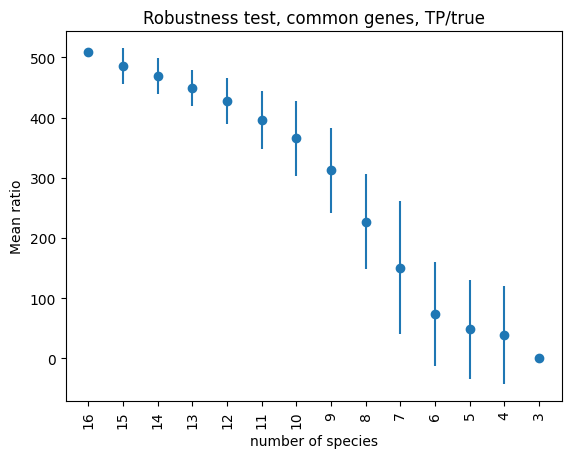

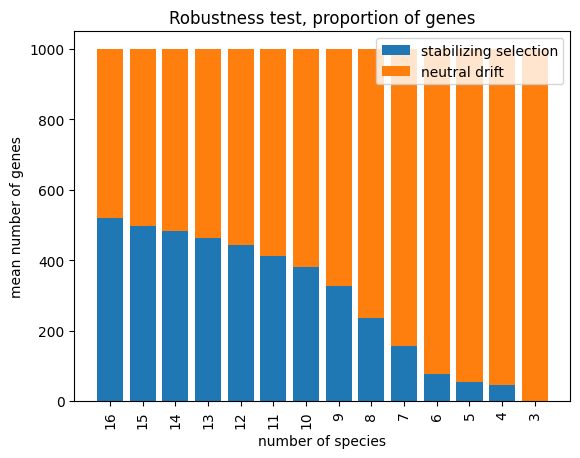

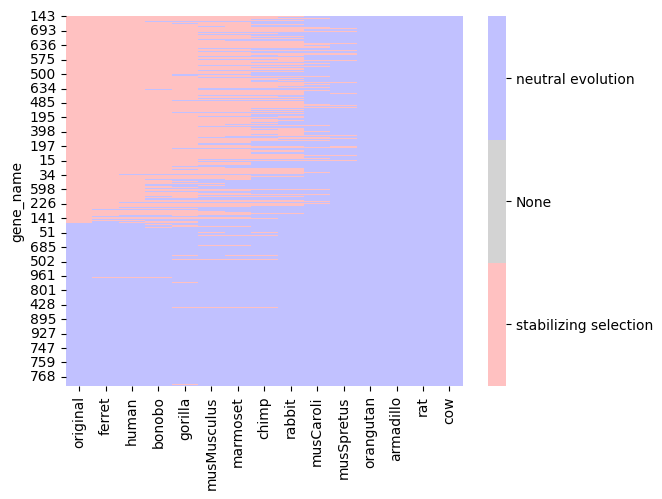

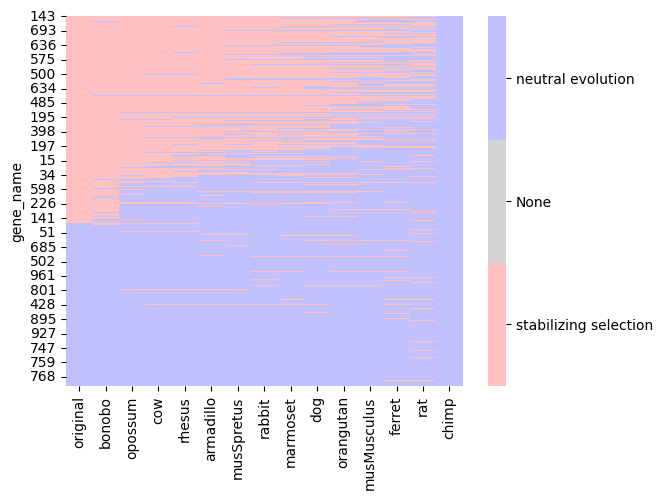

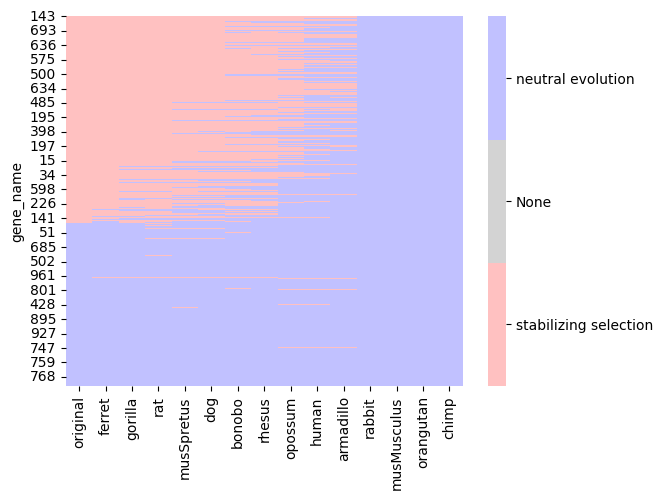

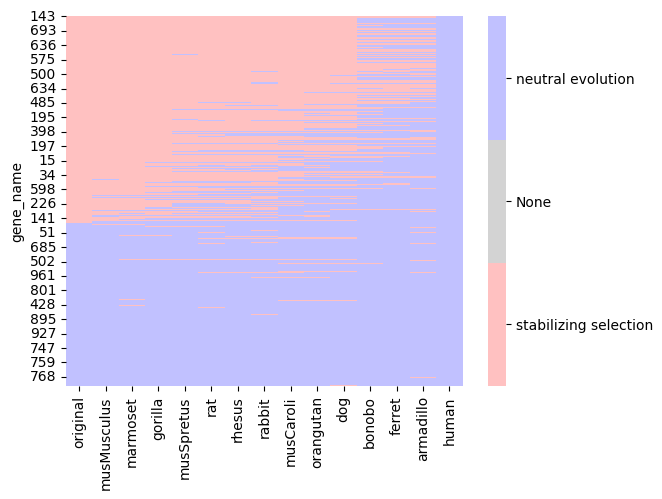

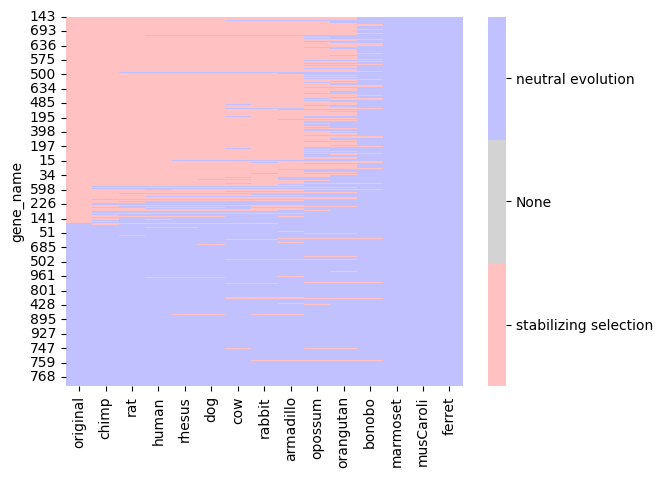

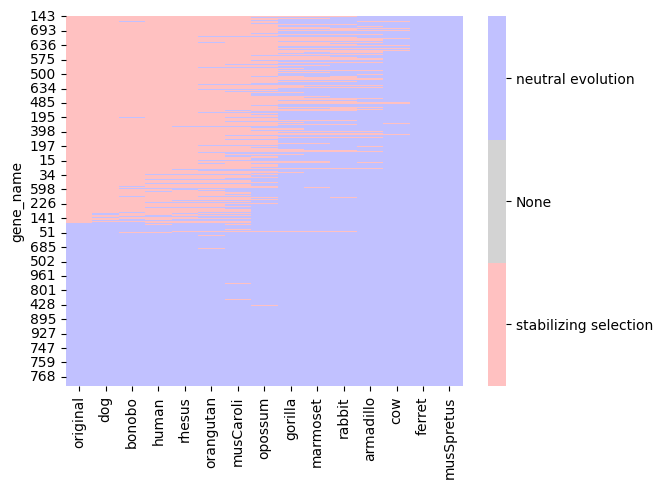

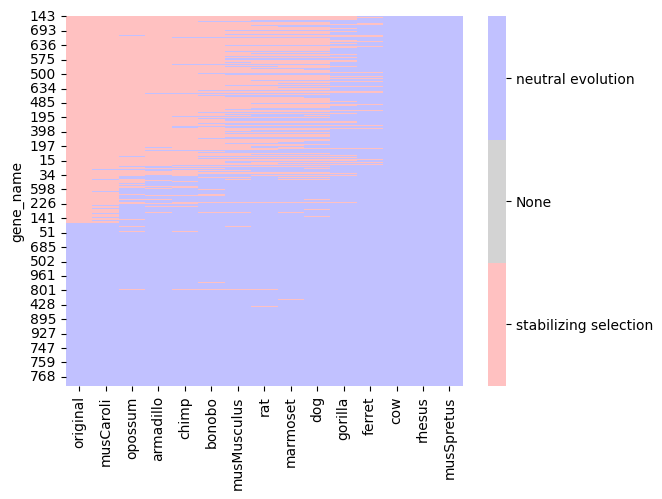

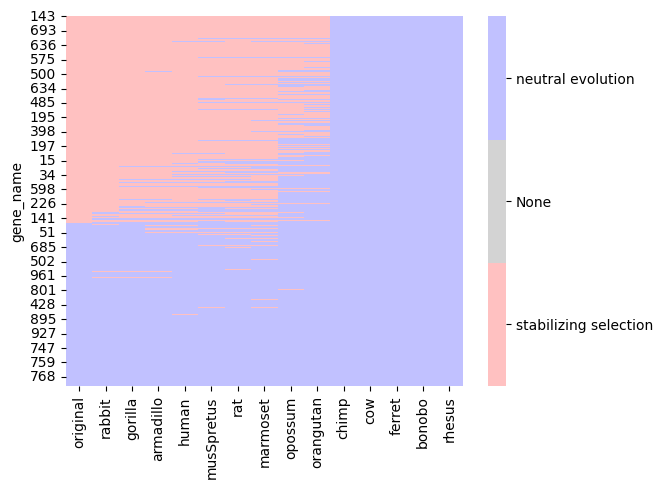

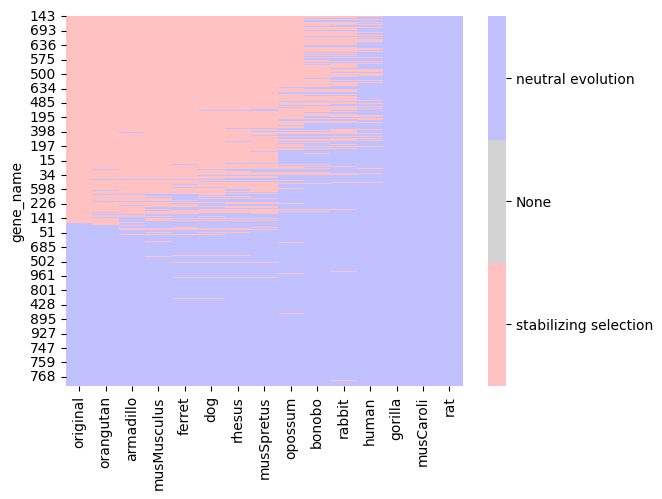

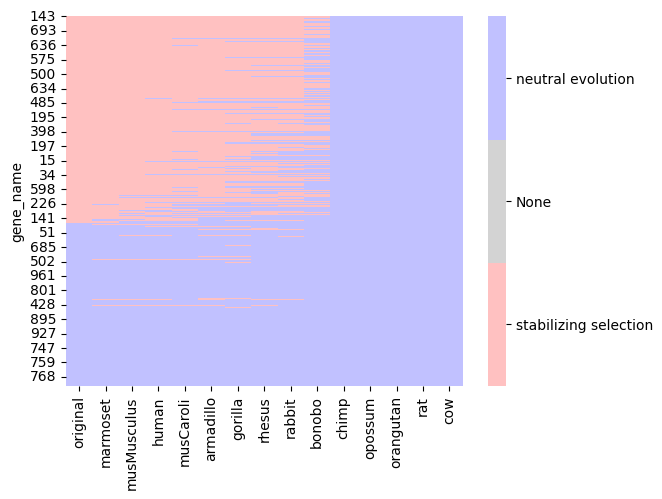

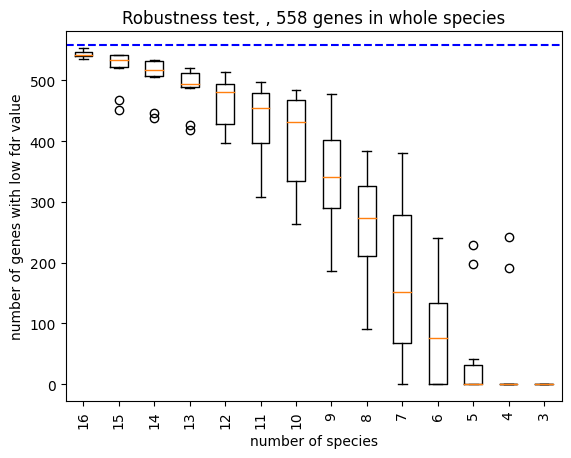

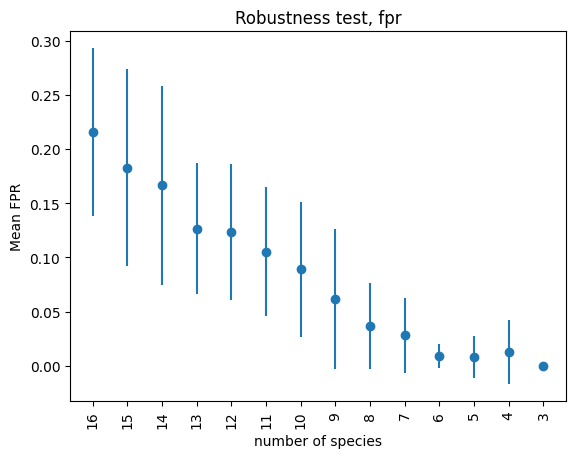

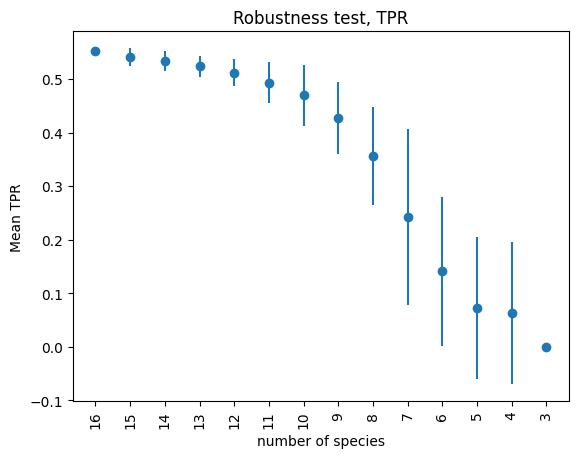

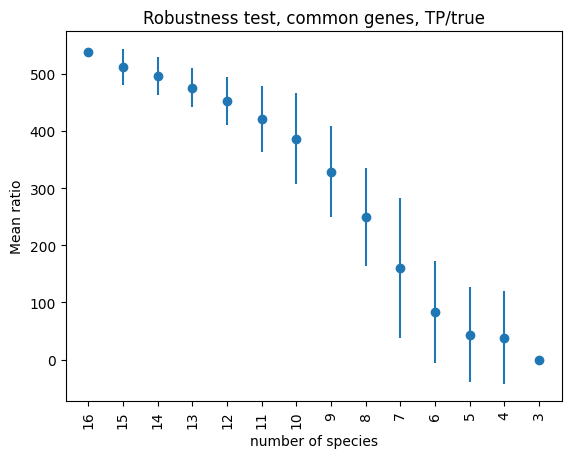

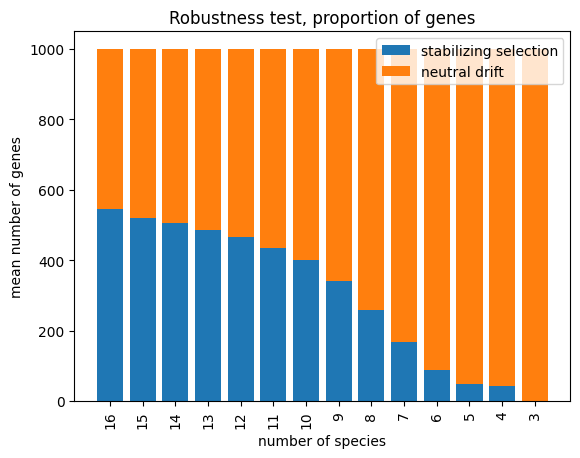

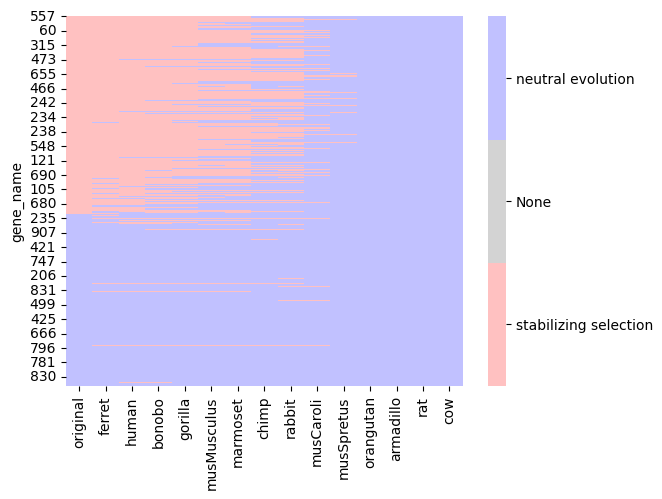

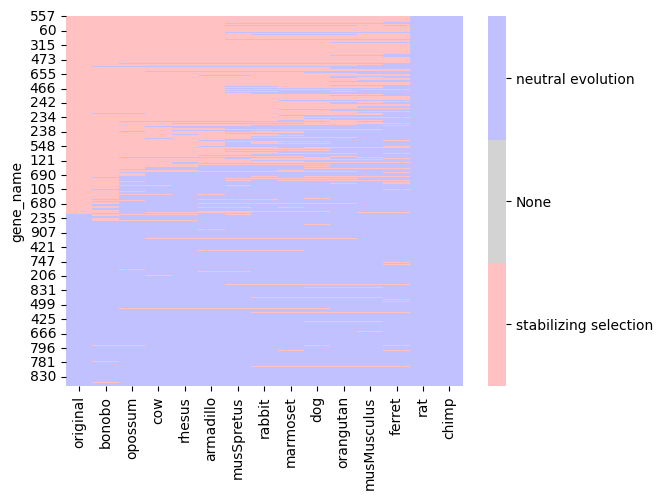

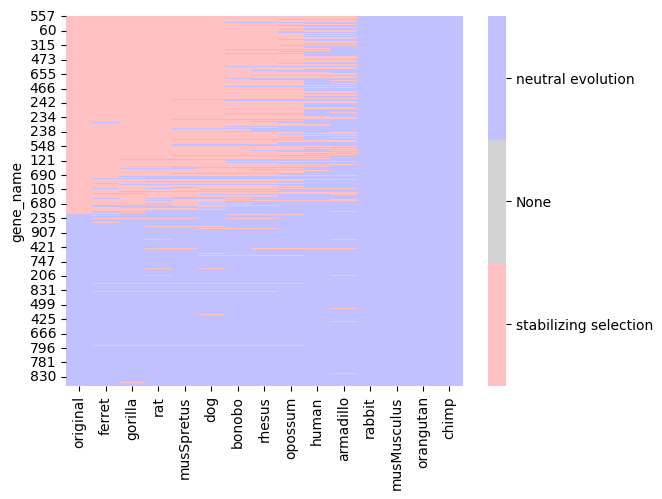

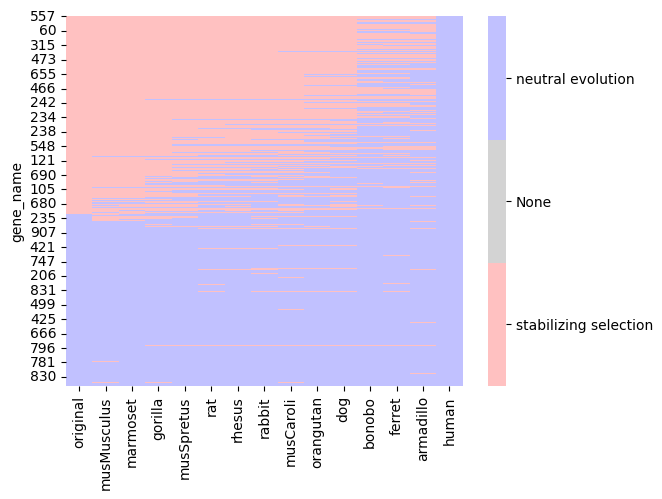

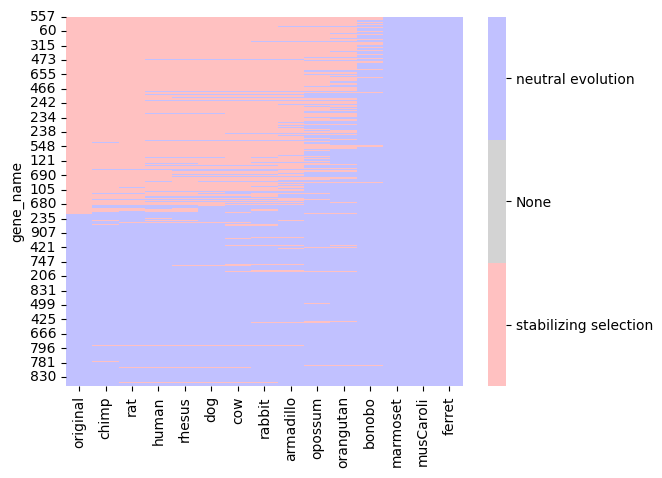

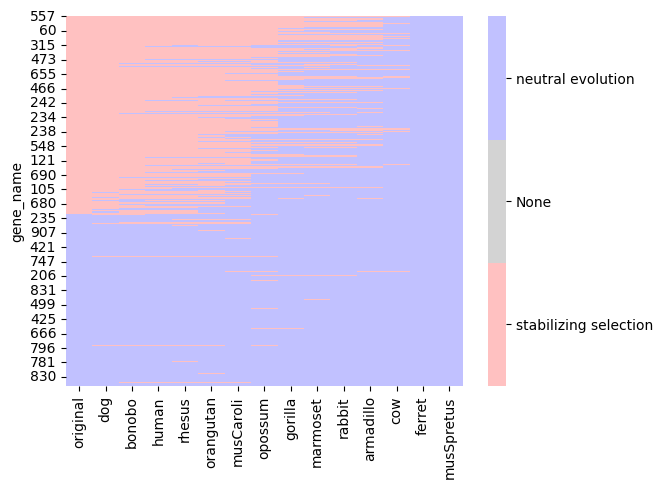

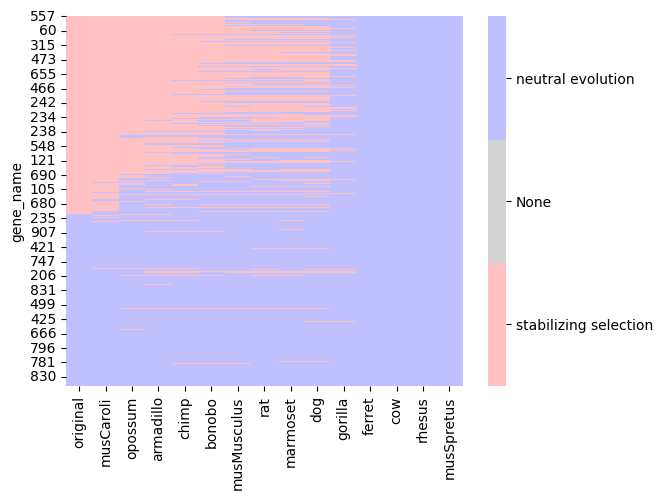

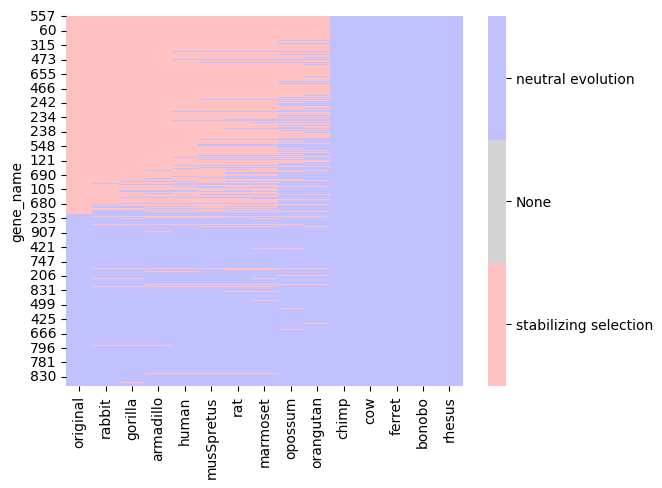

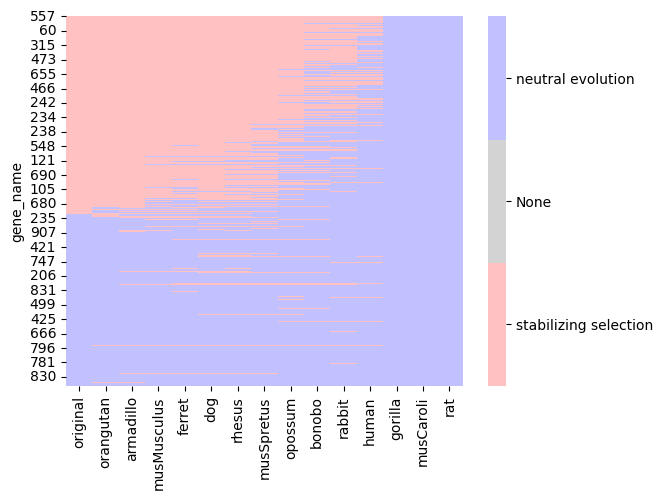

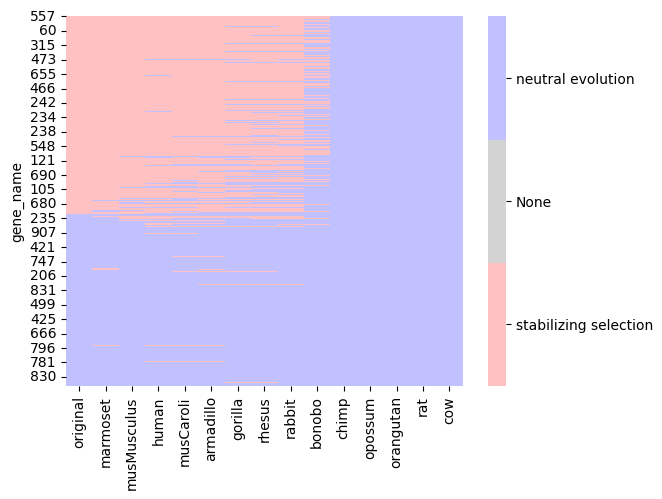

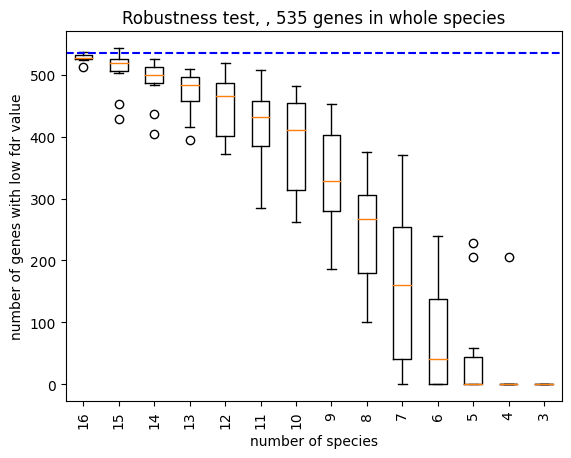

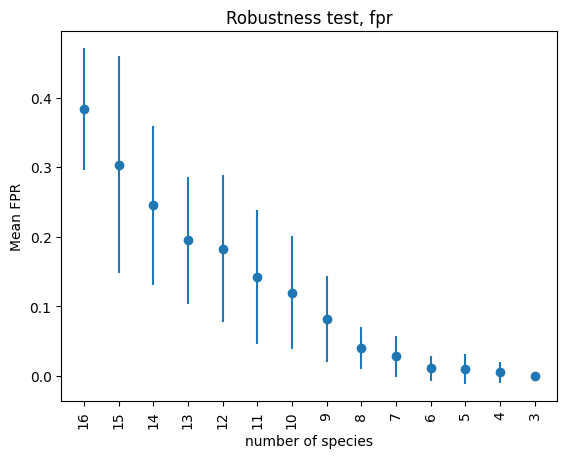

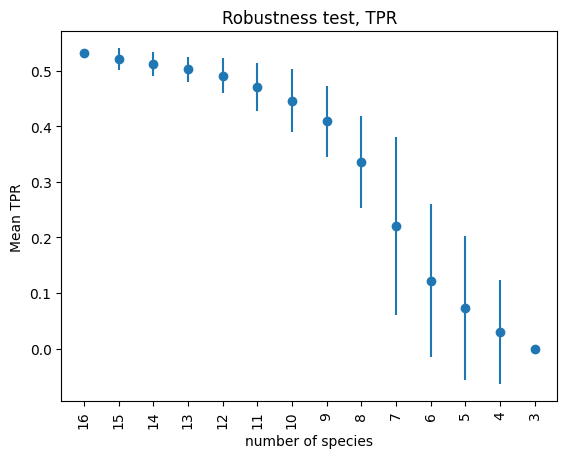

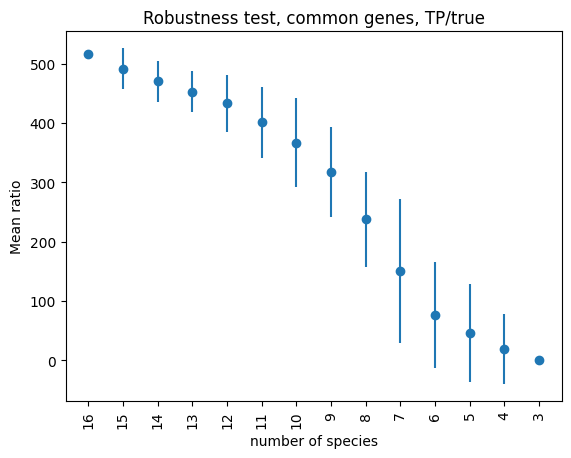

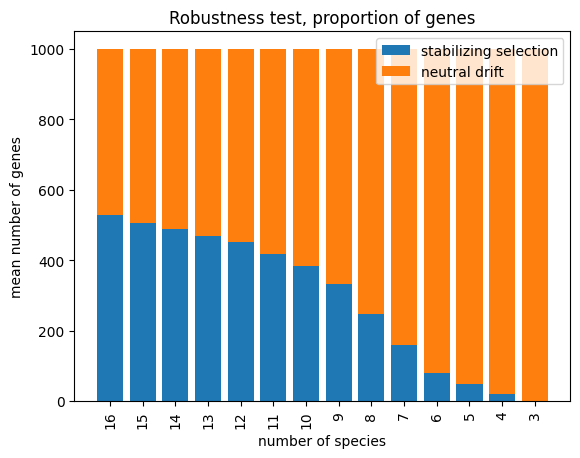

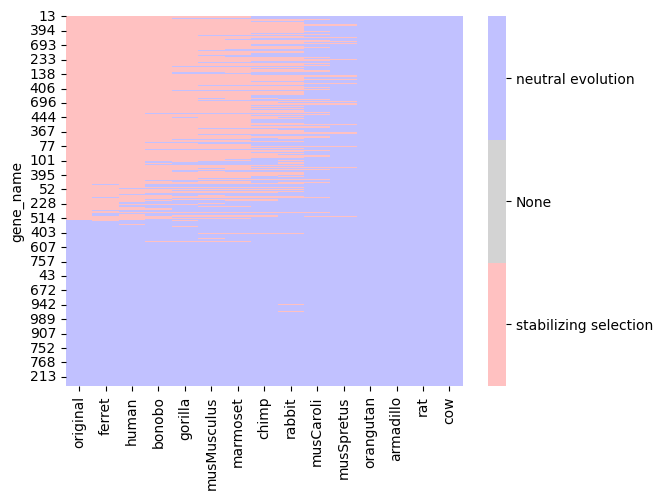

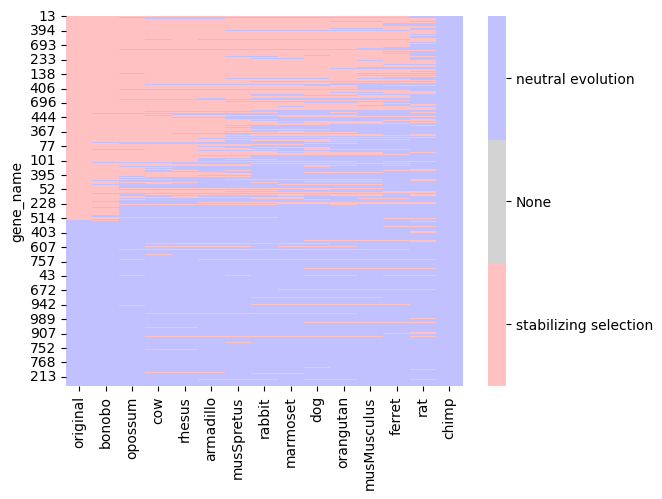

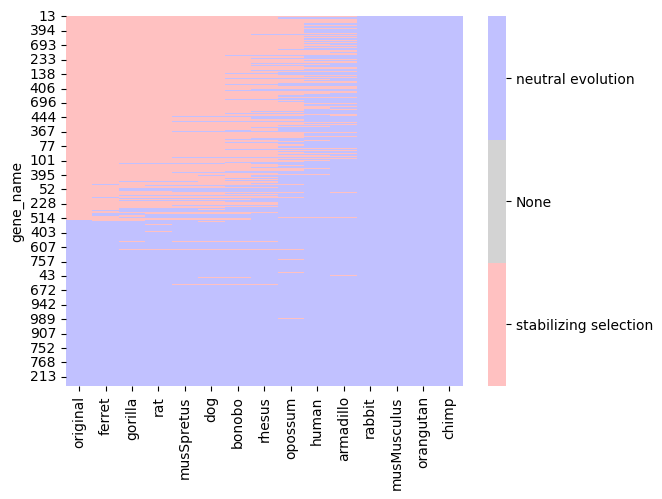

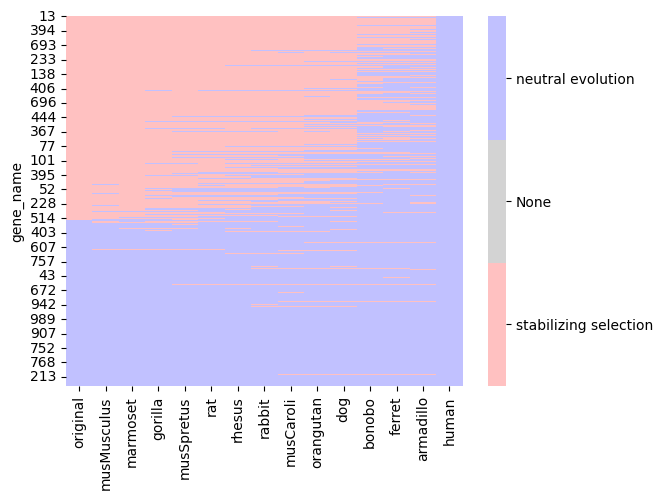

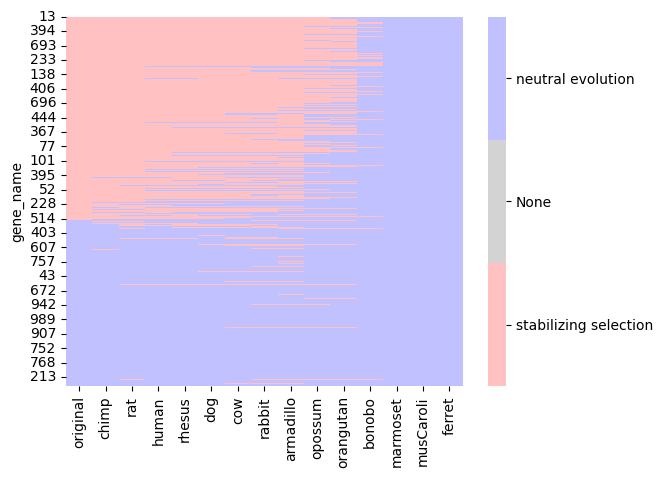

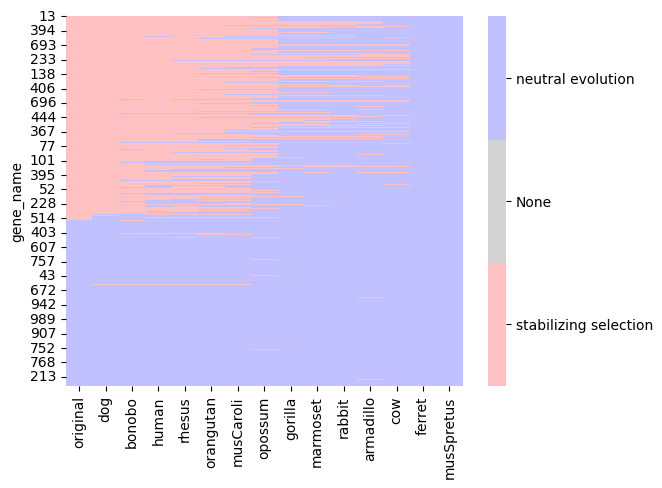

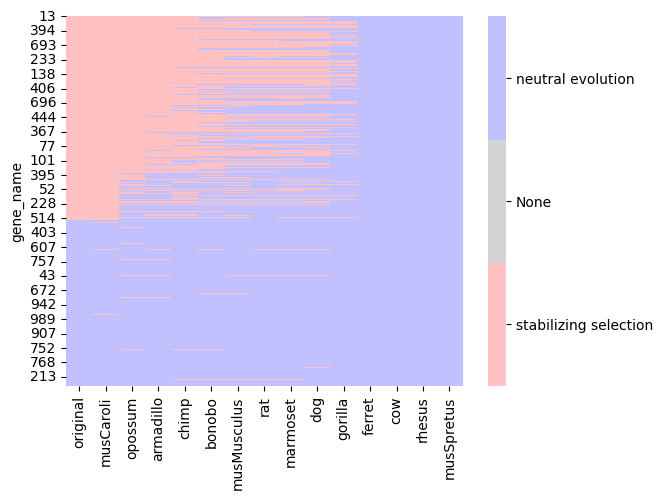

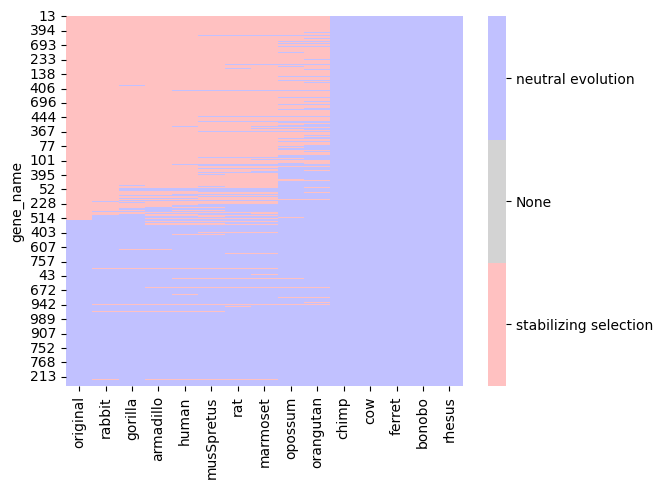

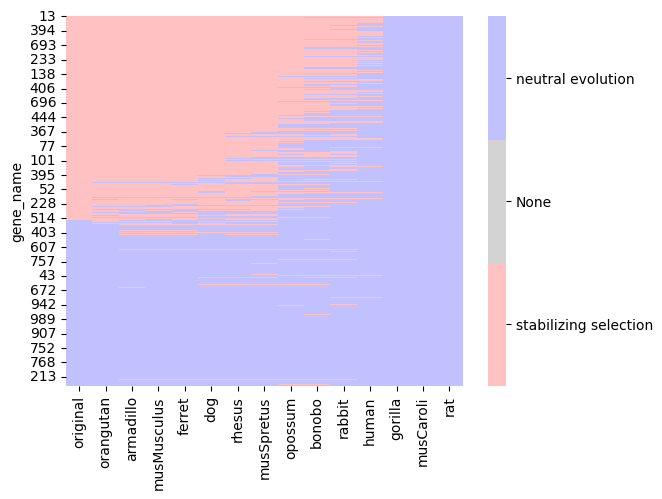

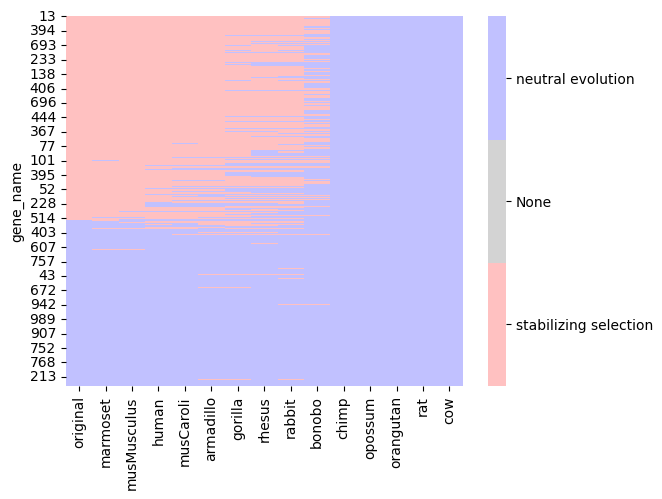

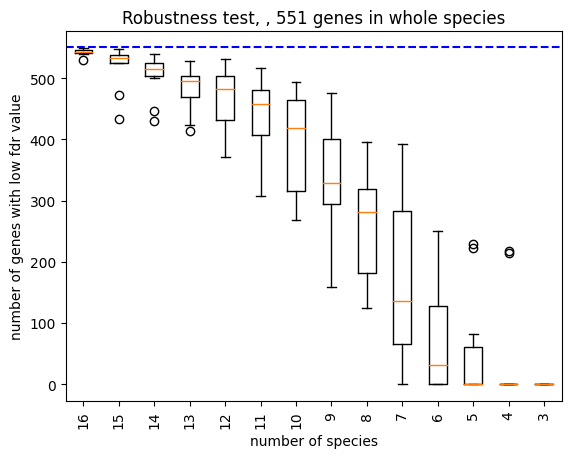

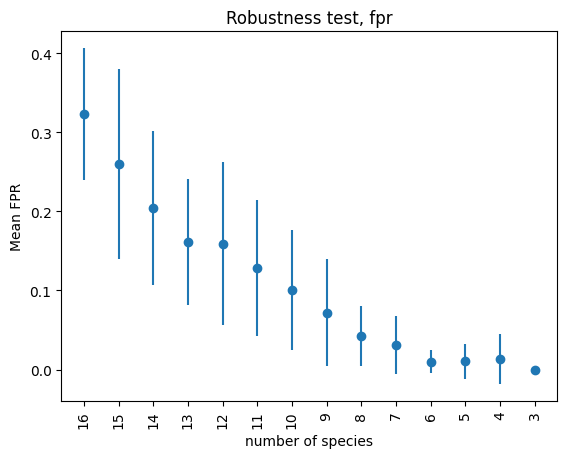

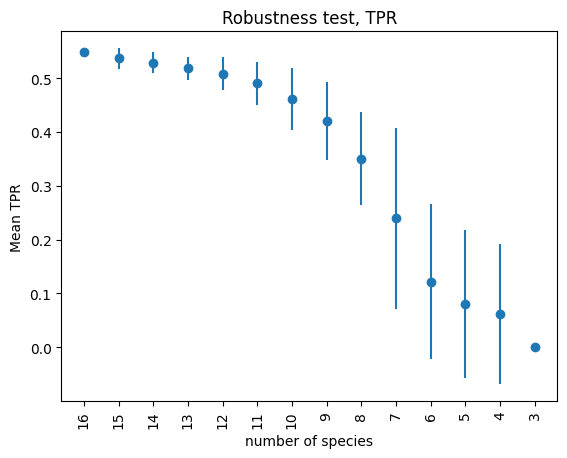

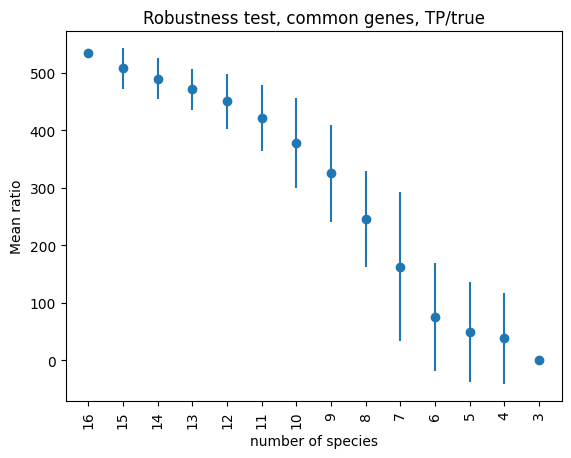

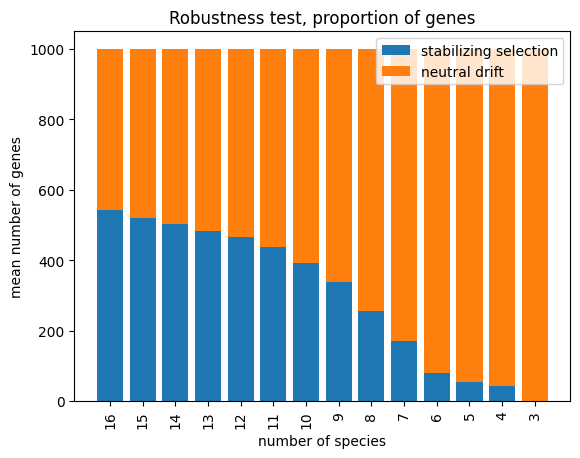

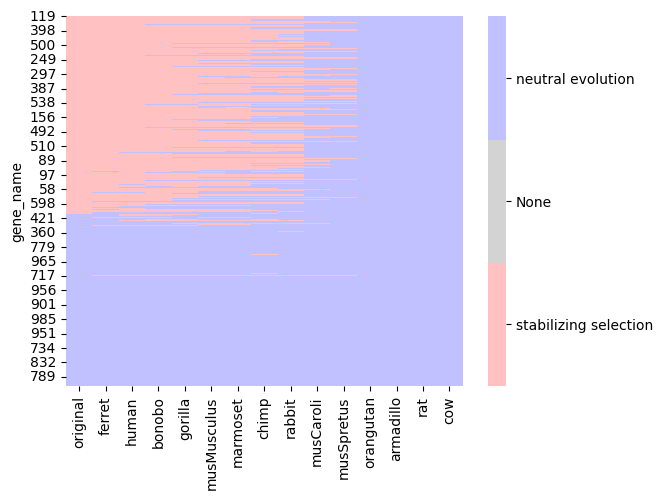

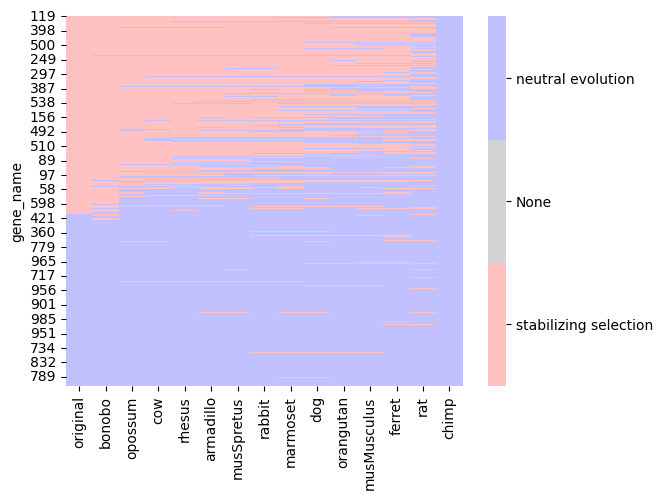

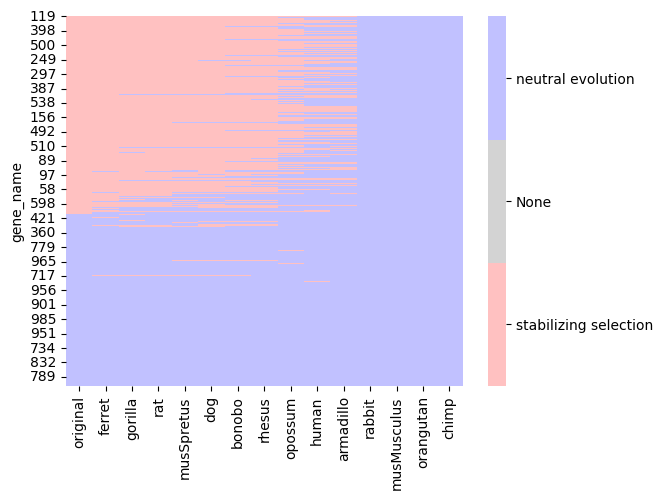

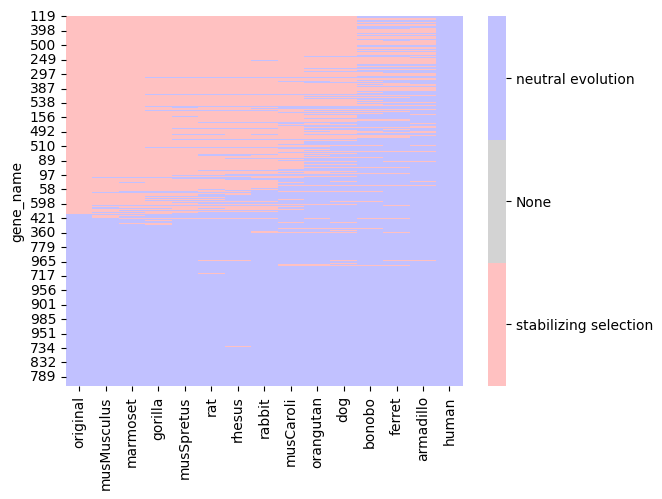

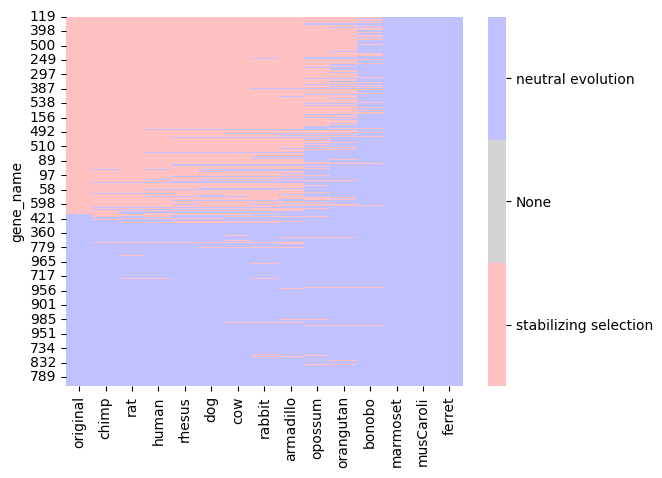

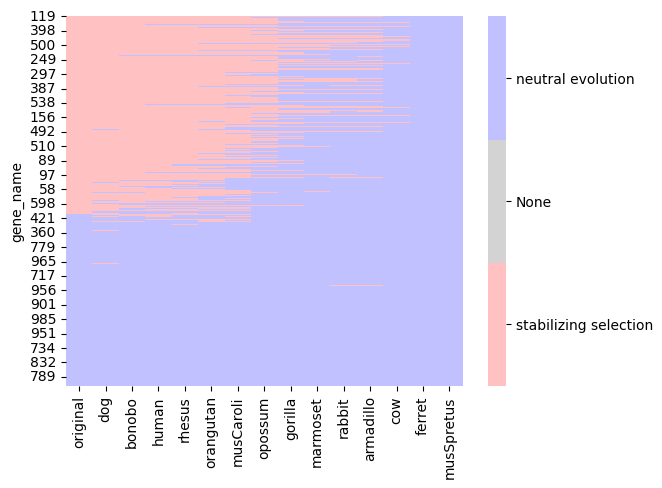

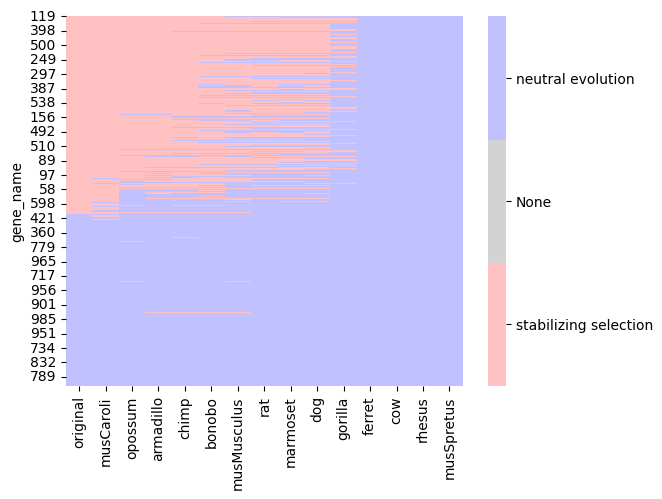

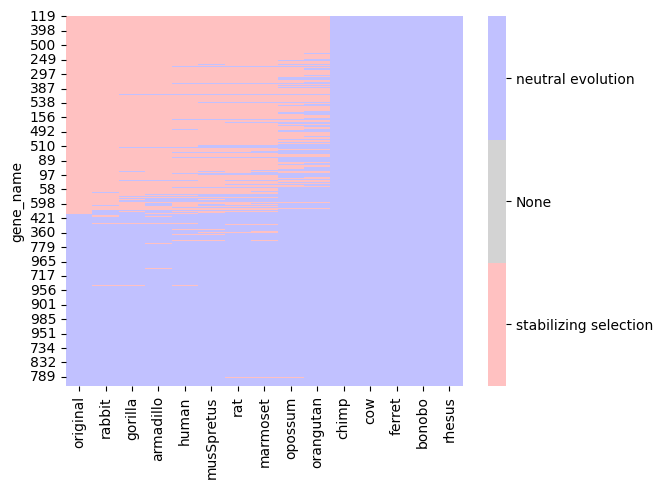

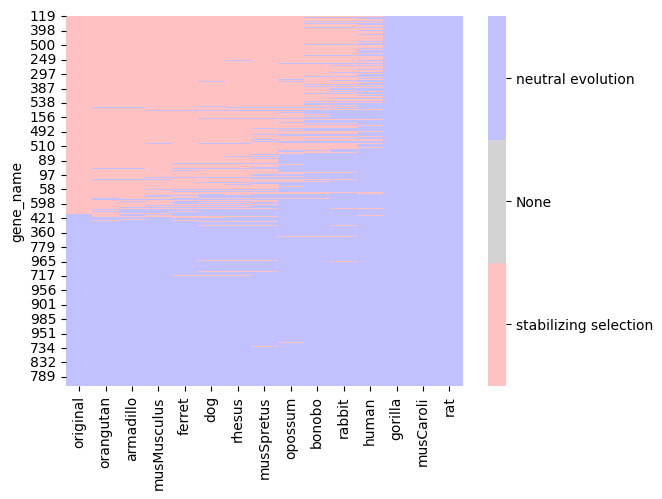

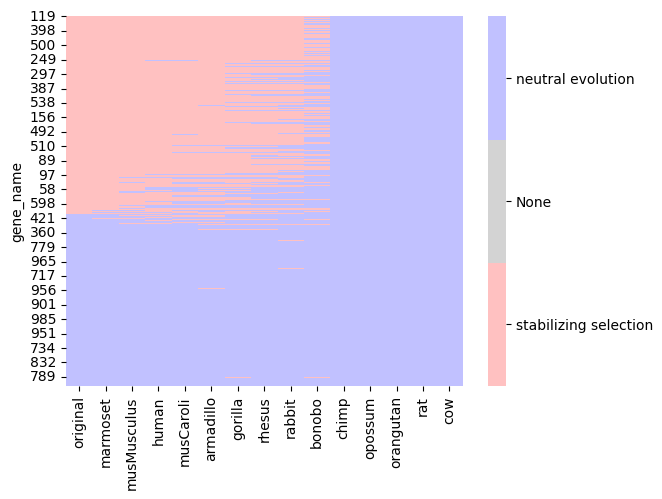

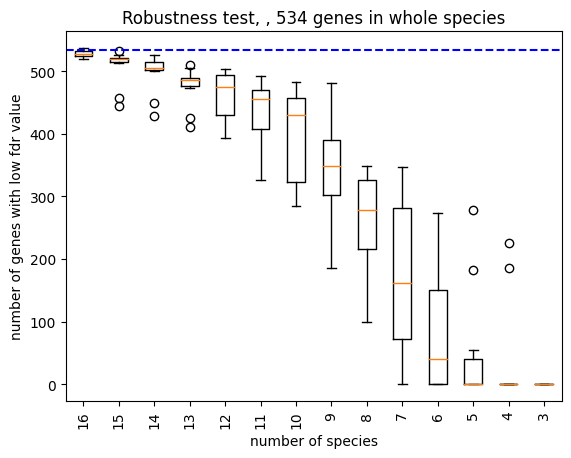

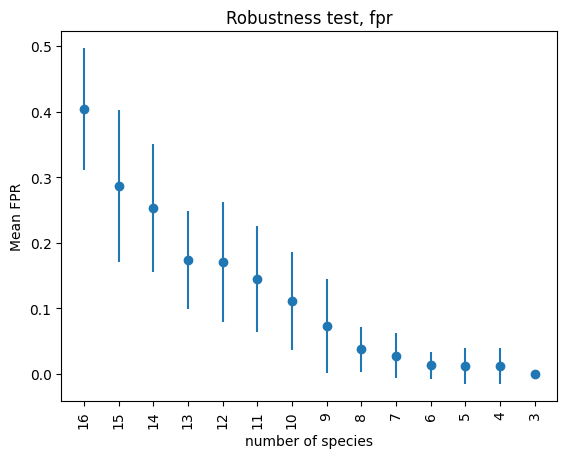

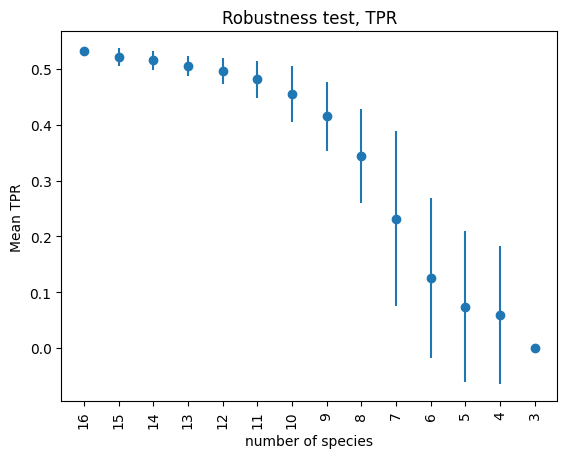

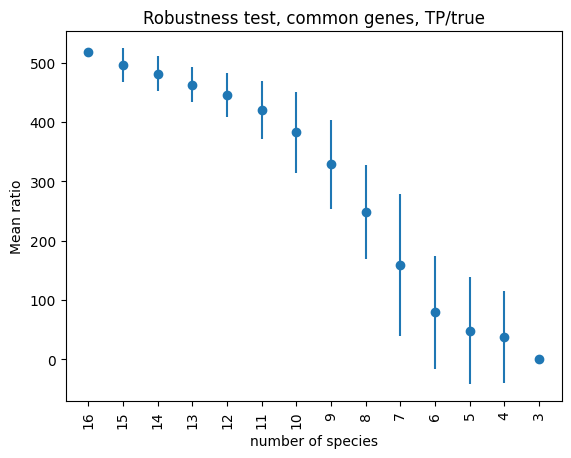

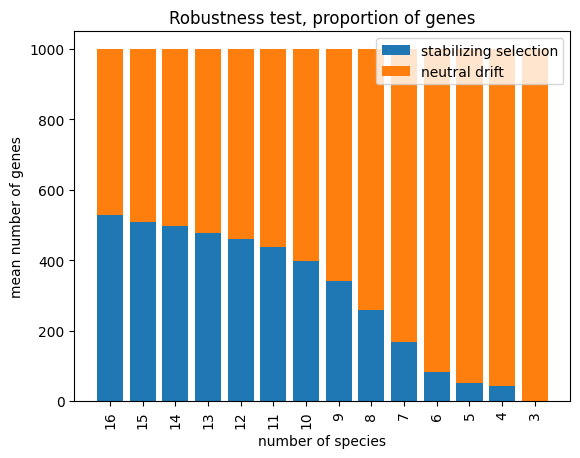

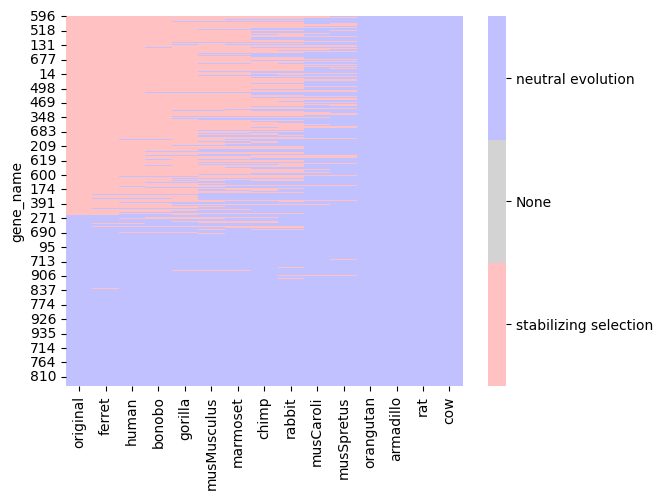

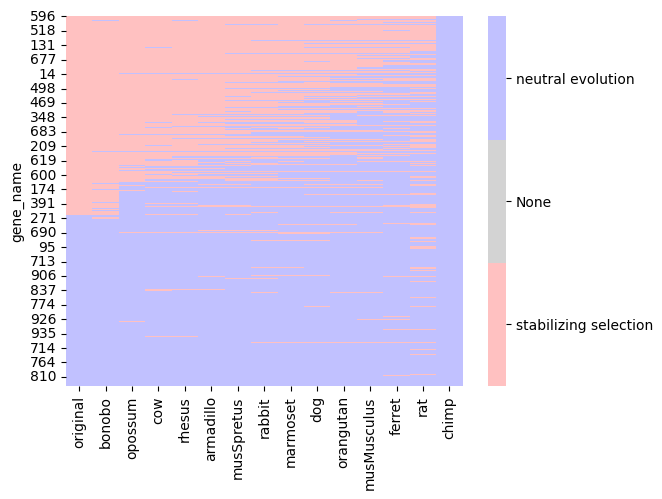

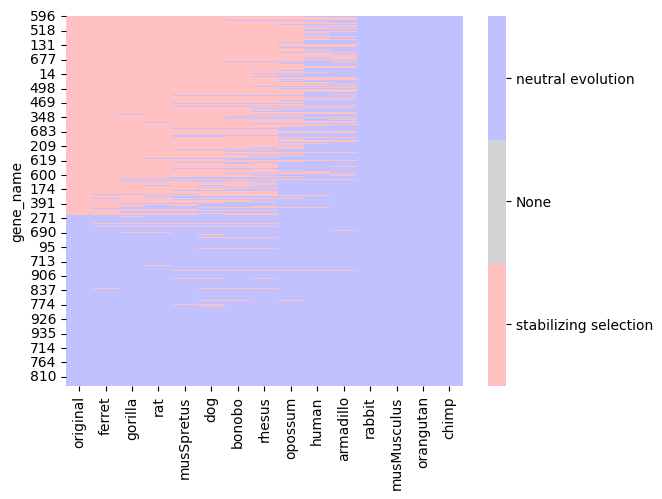

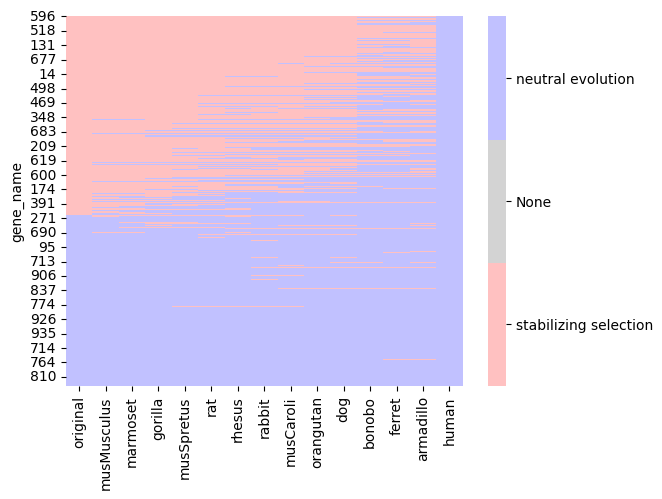

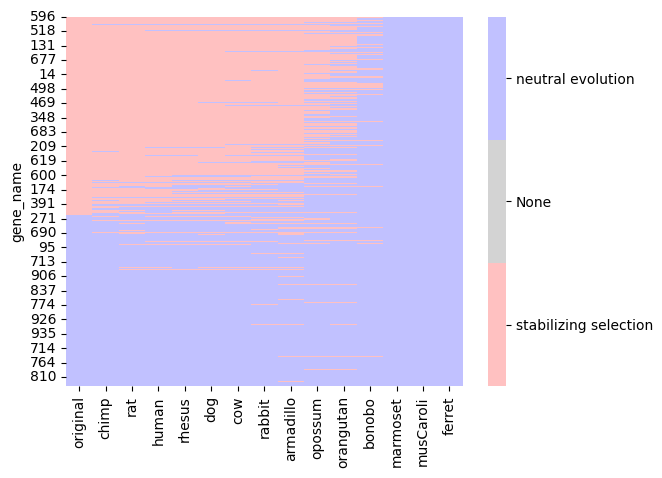

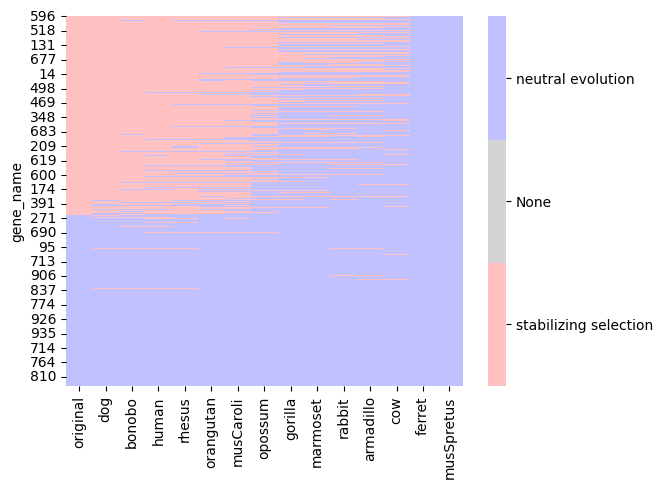

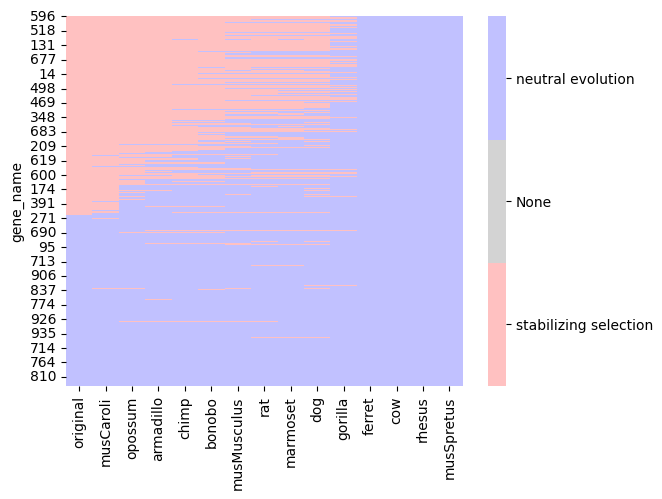

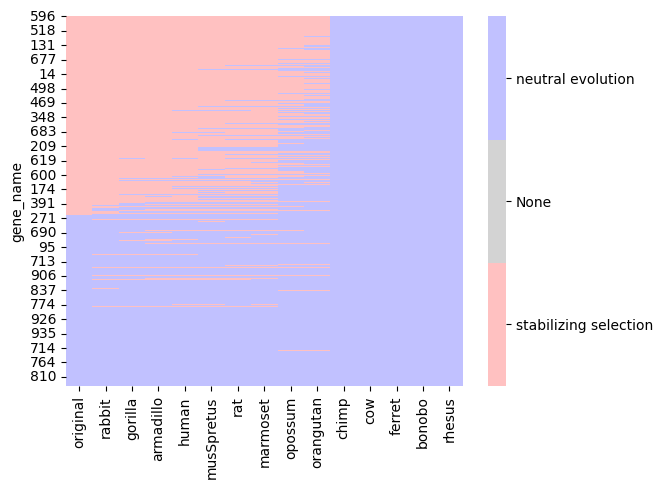

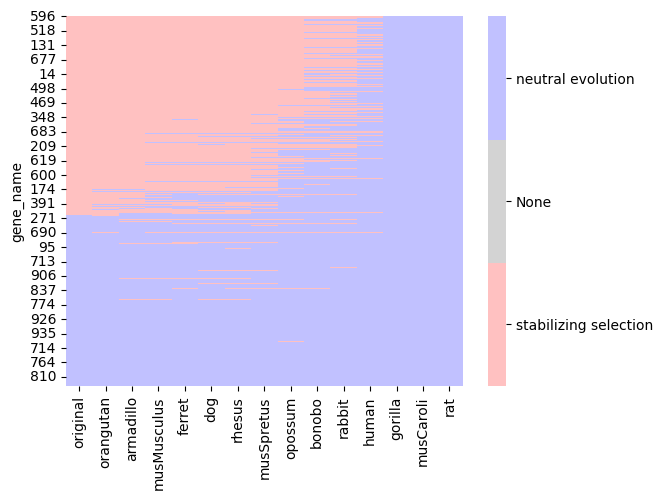

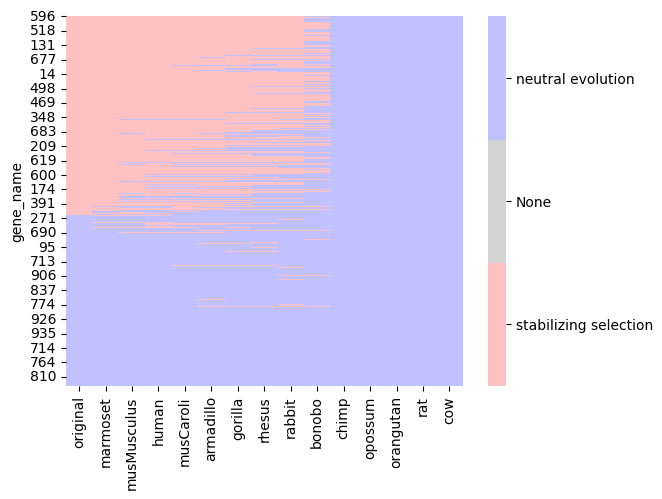

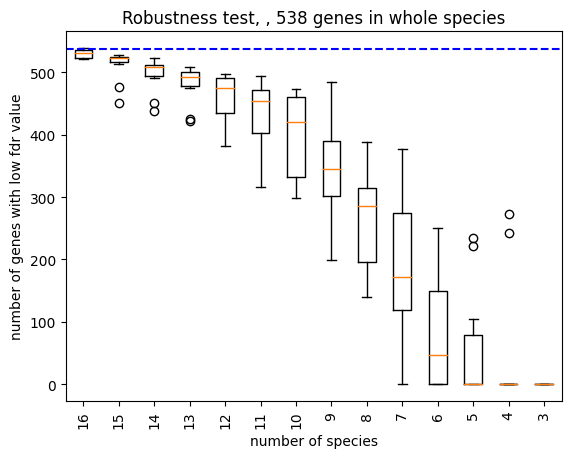

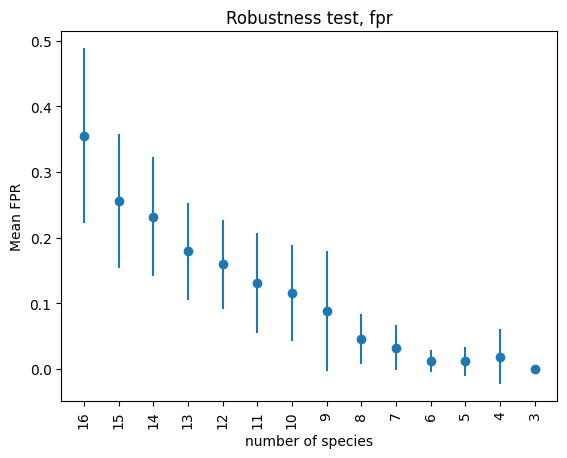

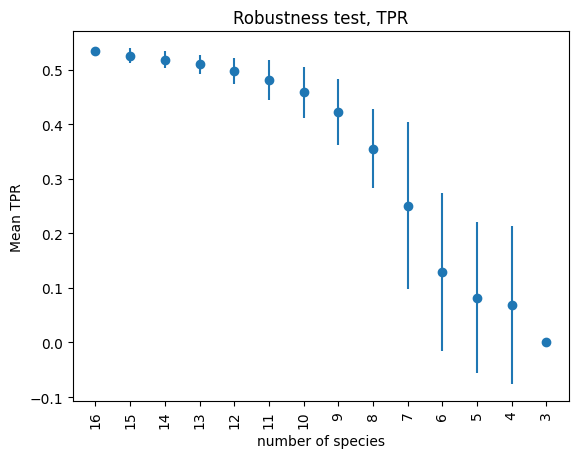

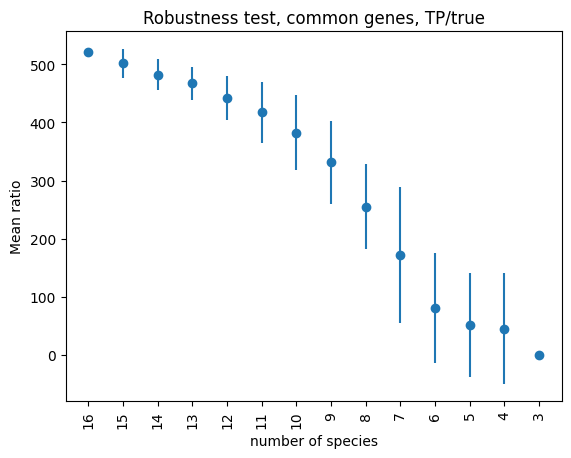

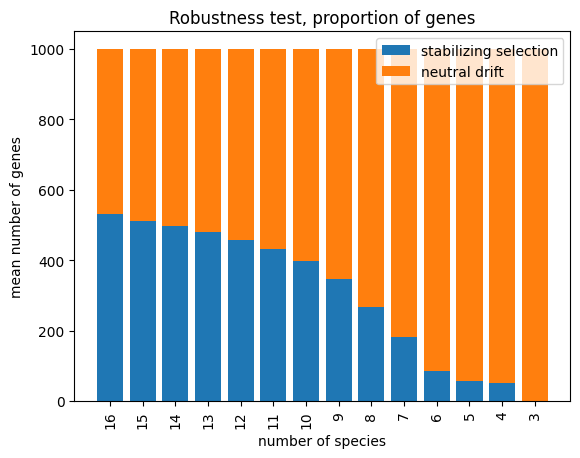

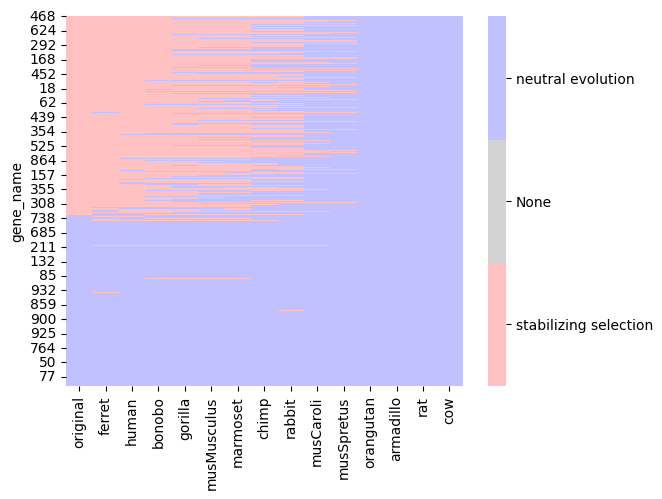

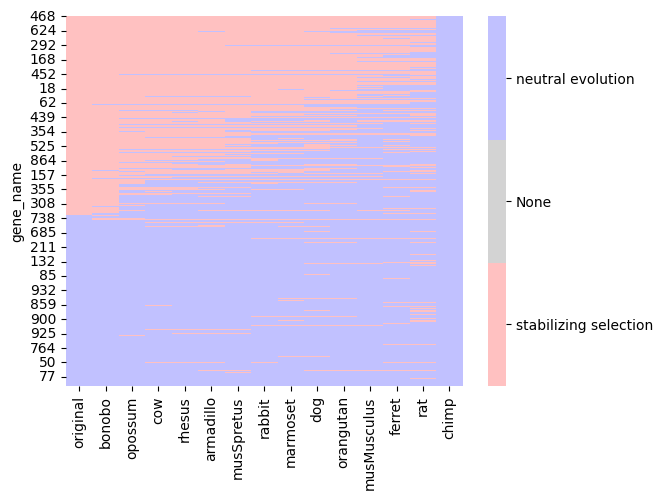

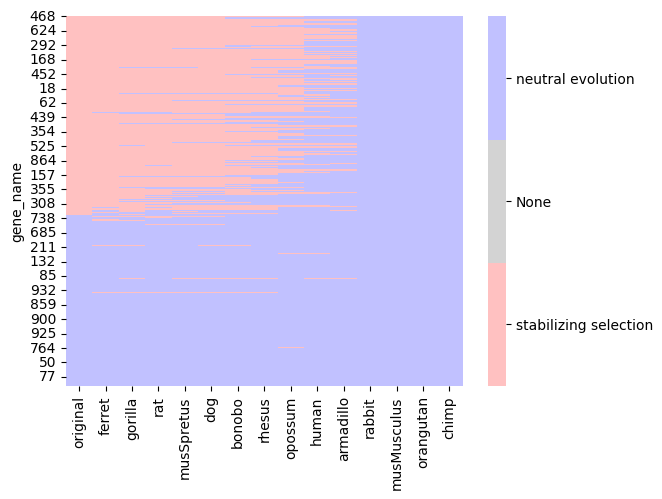

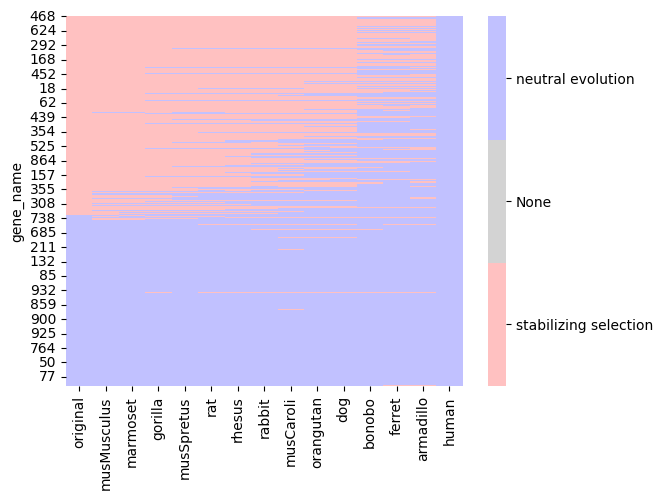

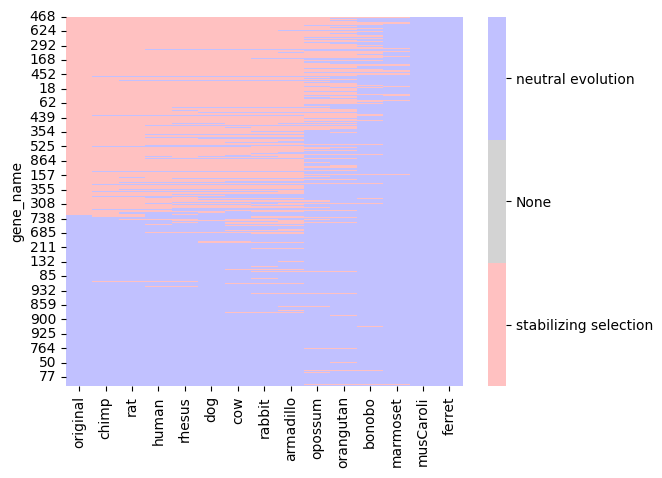

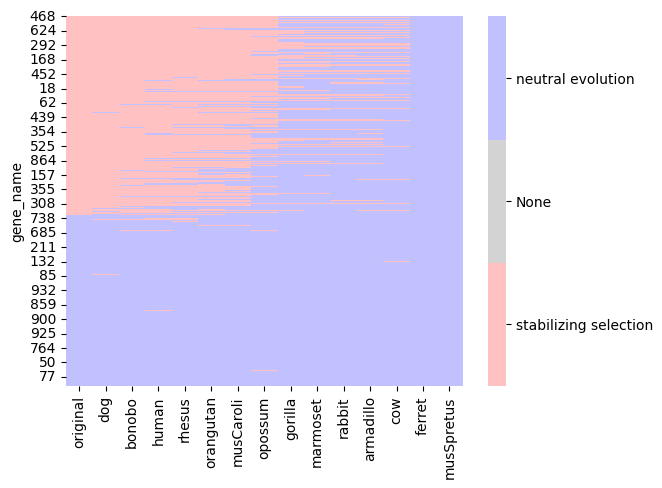

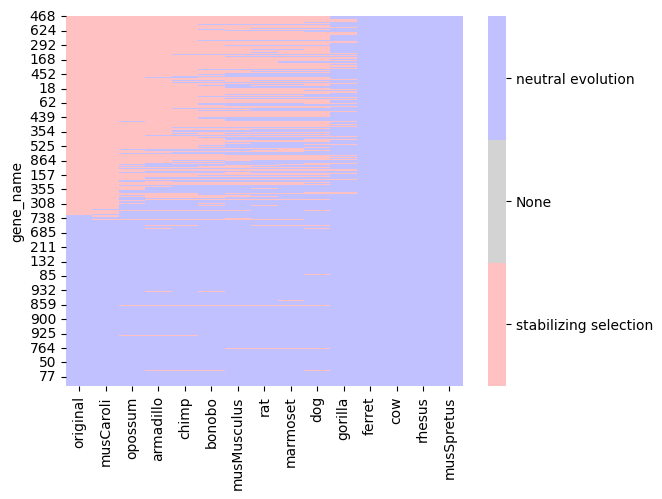

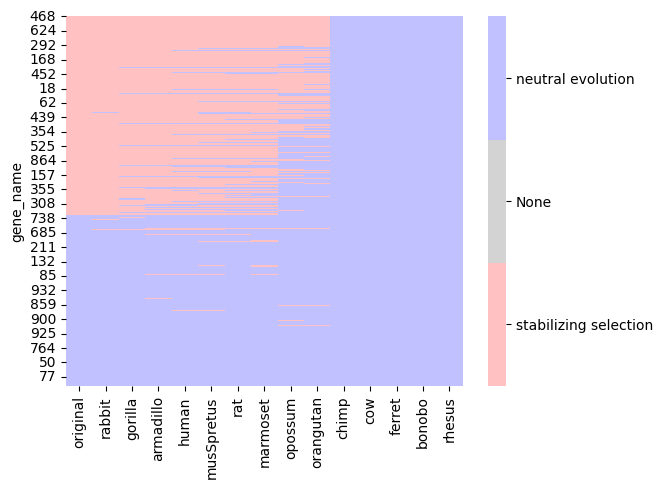

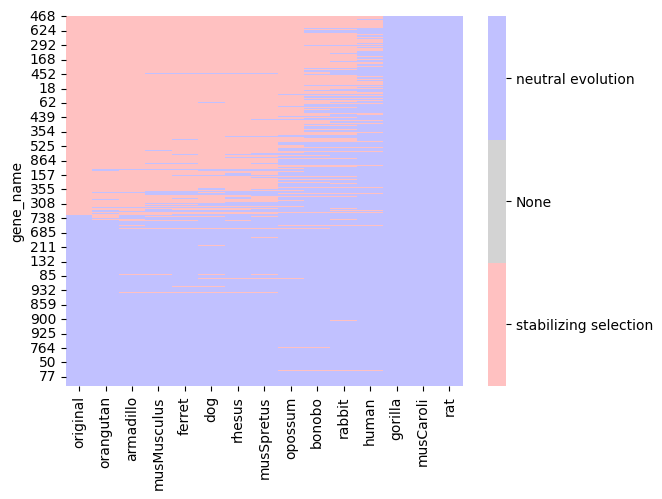

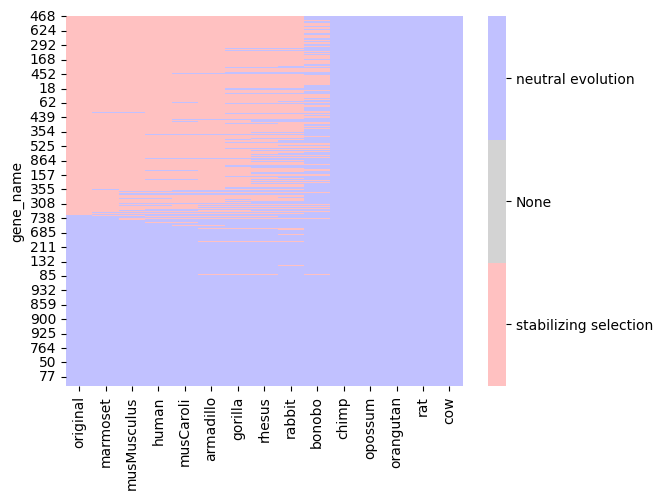

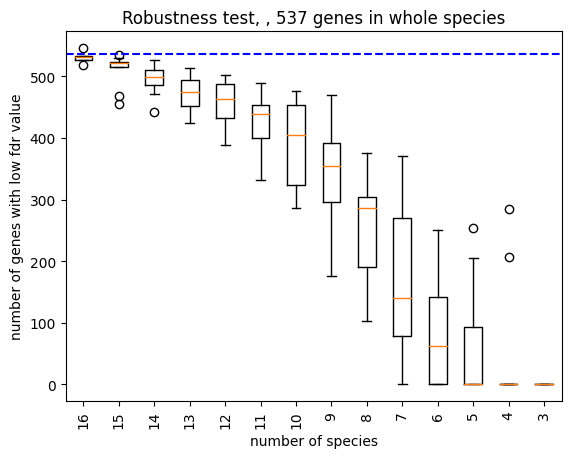

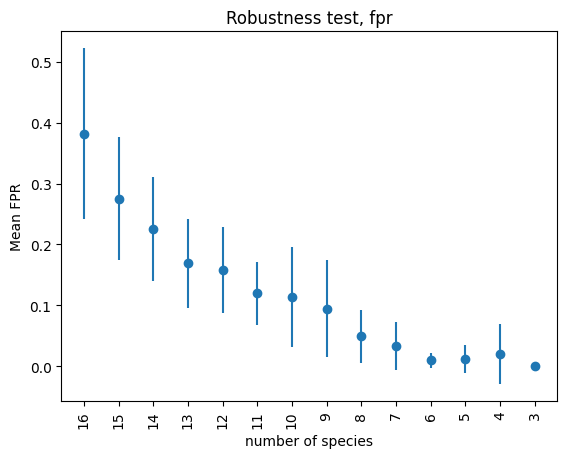

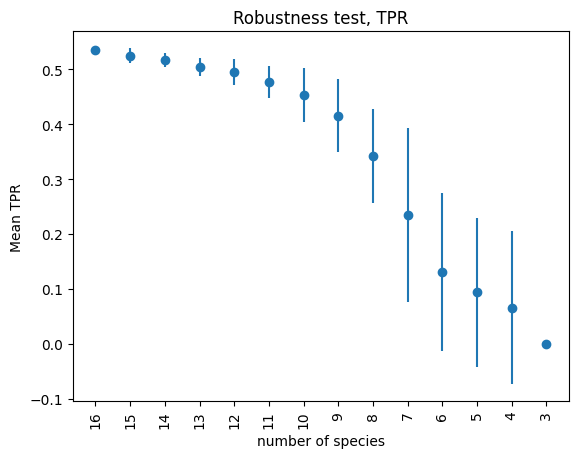

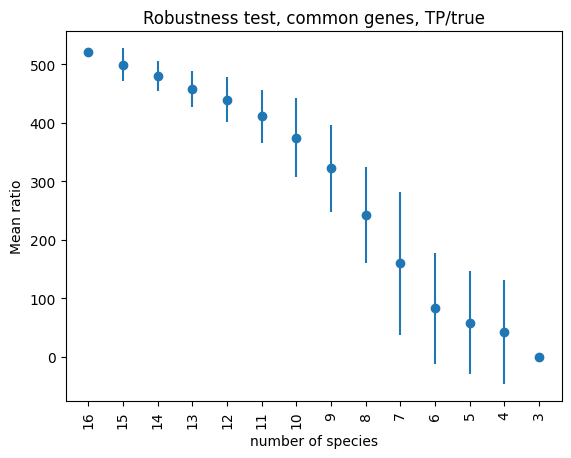

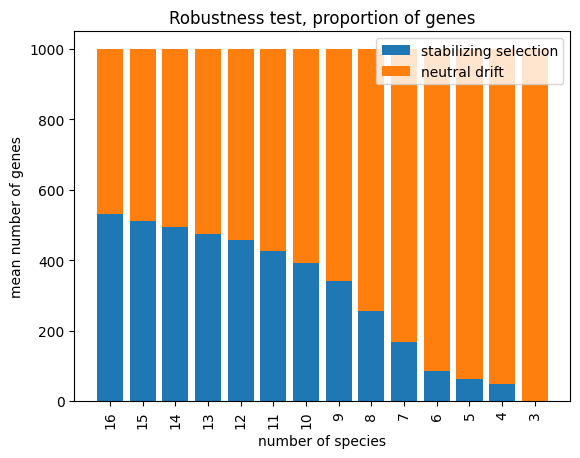

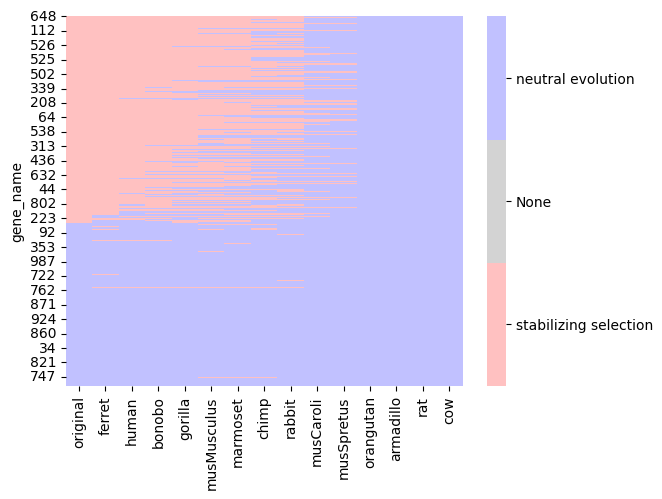

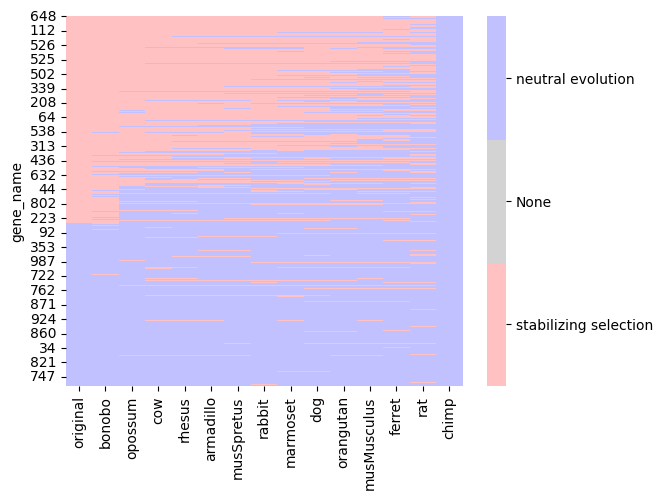

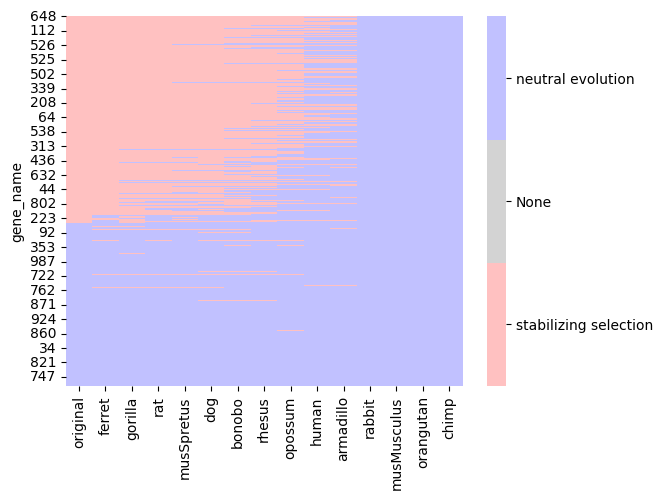

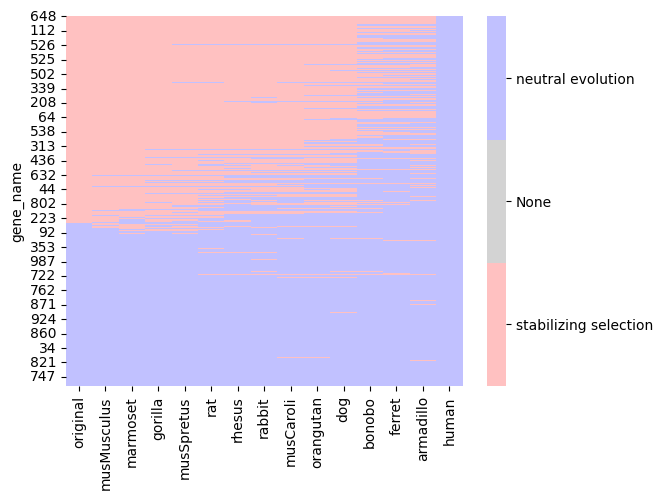

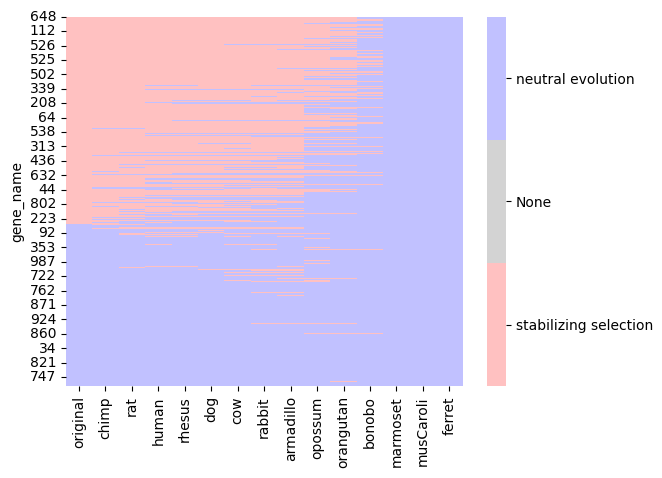

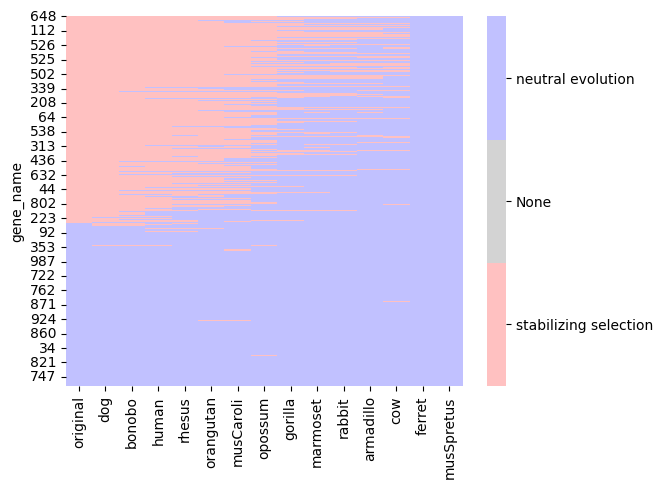

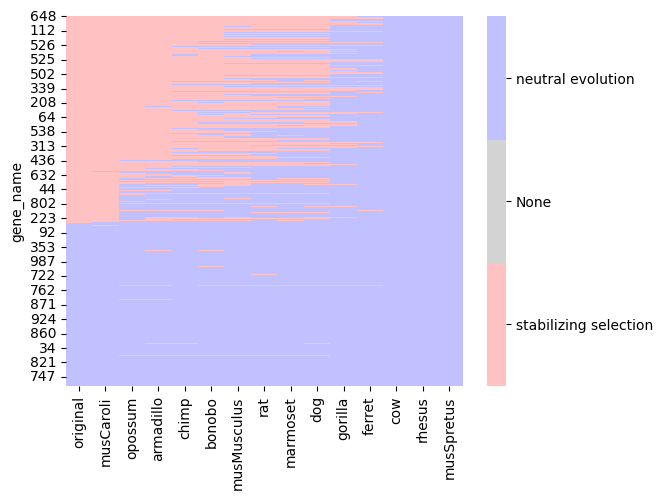

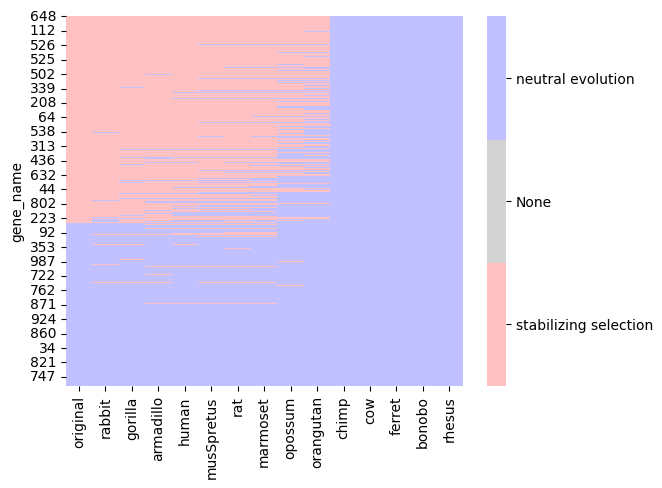

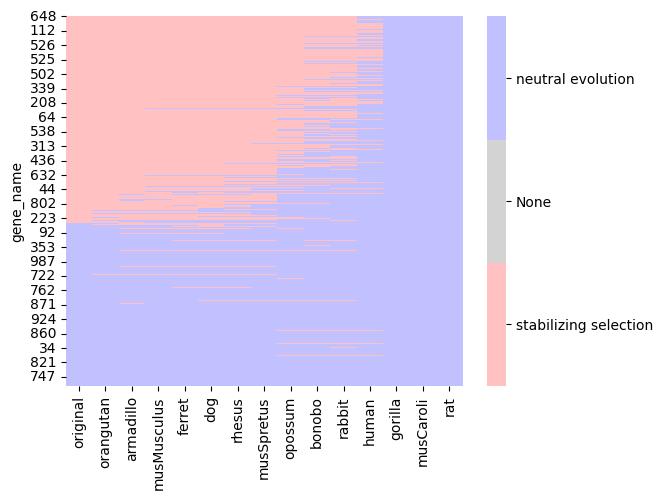

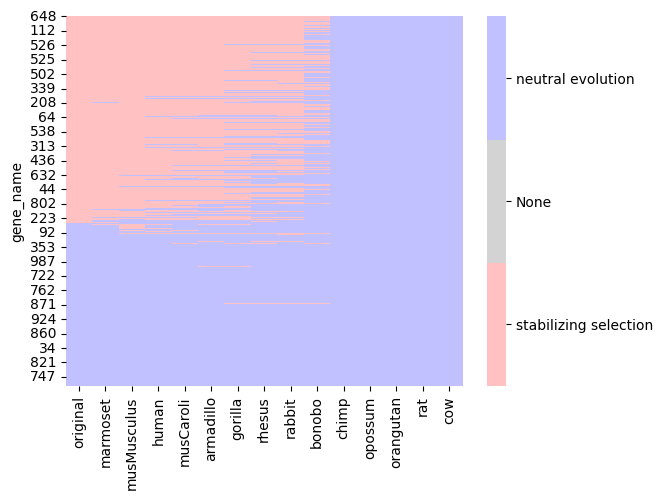

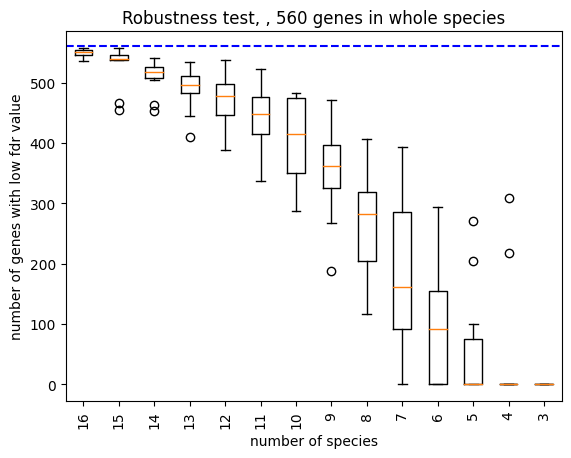

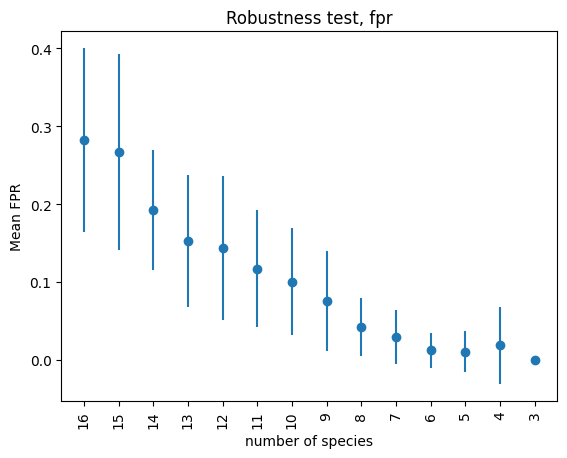

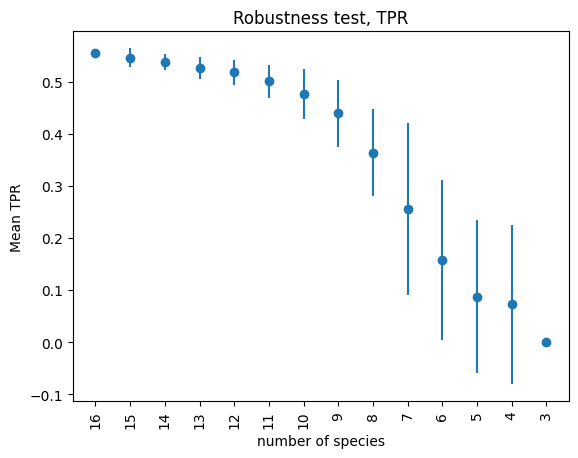

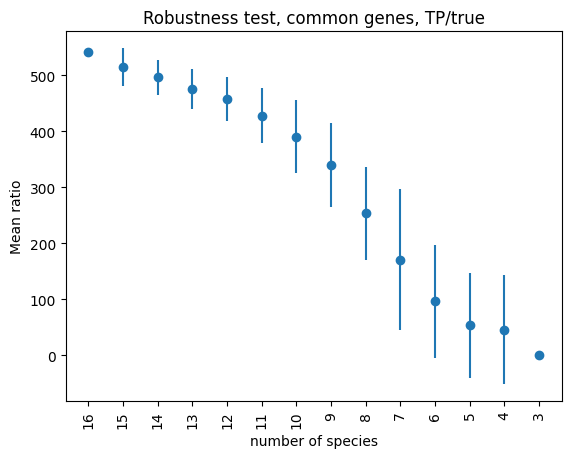

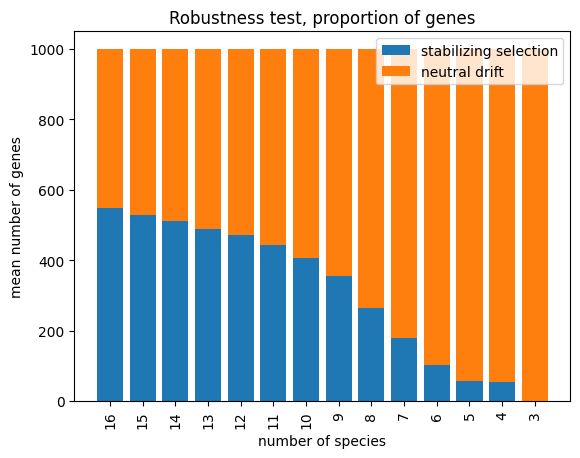

In [21]:
for i in range(3, 11):
    original = pd.read_csv(f"/Users/yunseong-eun/Desktop/simulation/R (1)/result/sim{i}_result.txt", delimiter = "\t")
    directory = f"/Users/yunseong-eun/Desktop/simulation/R (1)/robustness1/{i}/"
    outpath = f"/Users/yunseong-eun/Desktop/simulation/R (1)/robustness_result/{i}/"
    r = RobustTest(original = original, species = species, directory = directory, outpath = outpath)
    db = r.heatmap()
    r.plot()

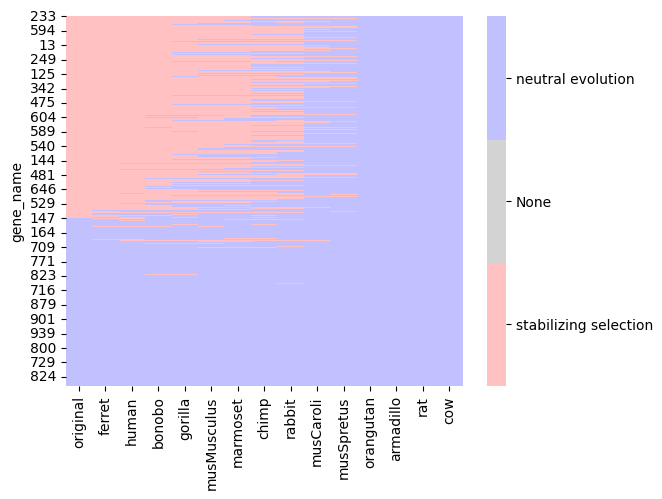

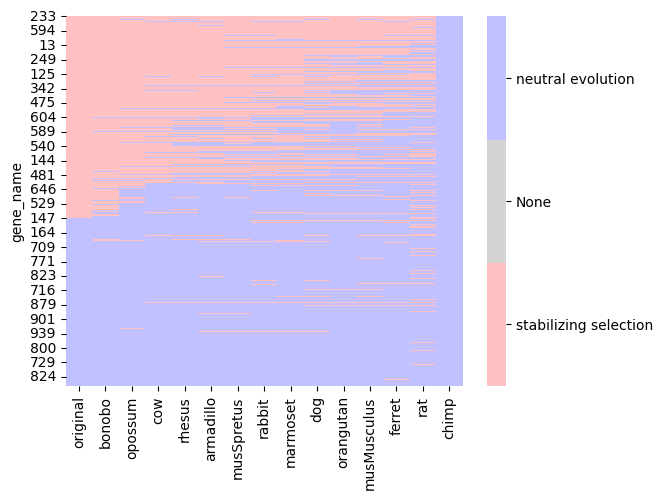

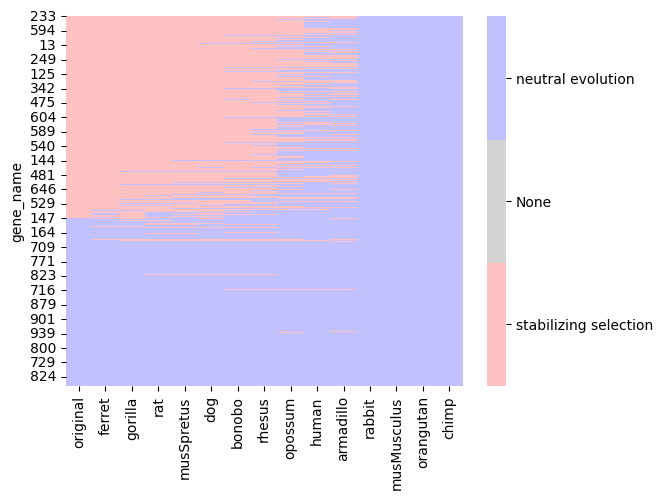

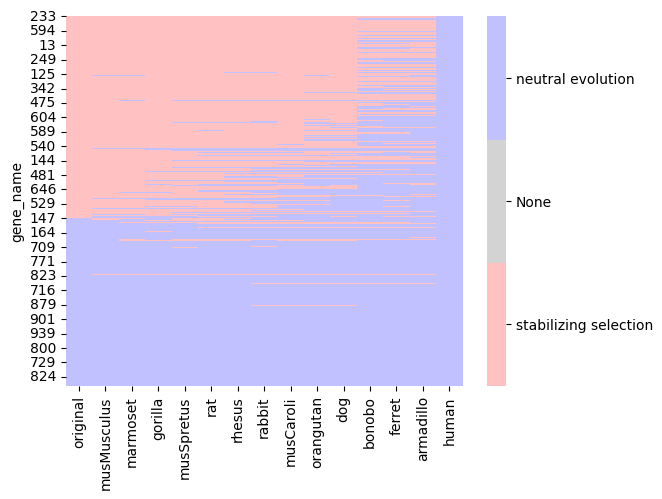

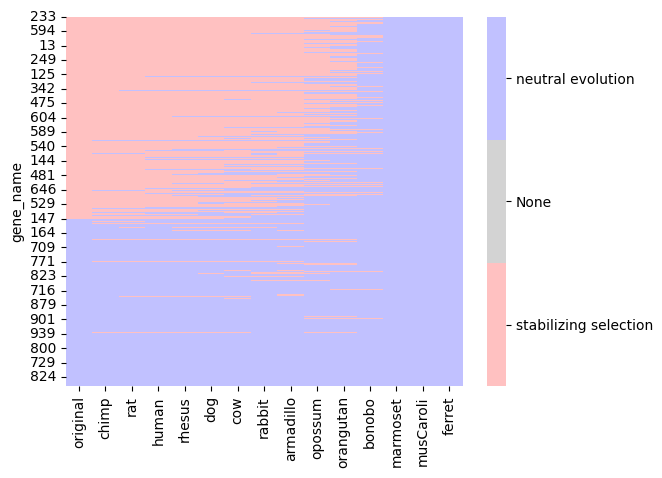

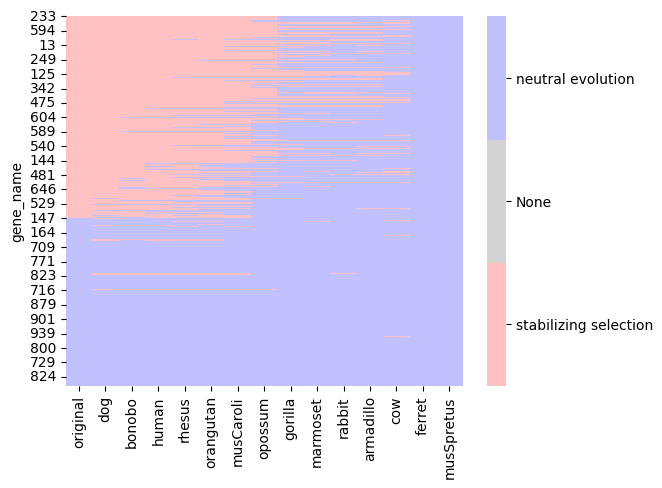

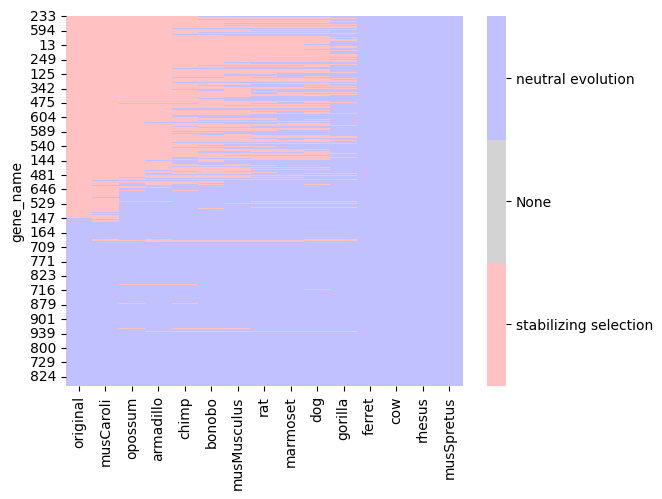

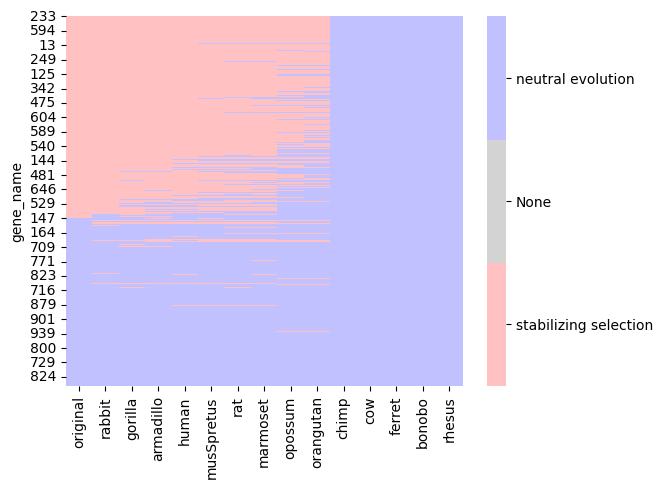

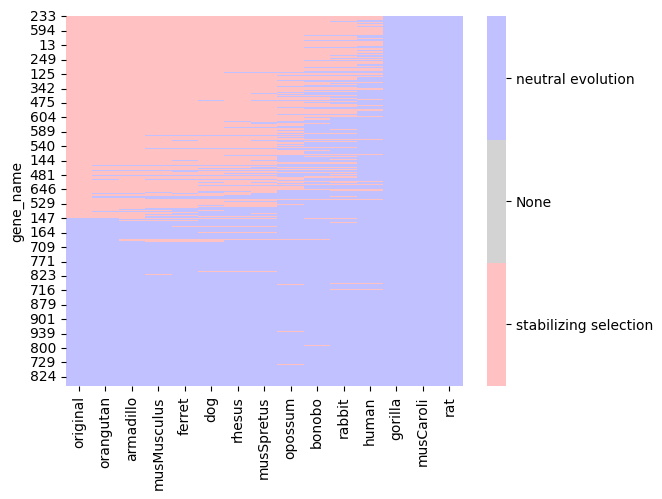

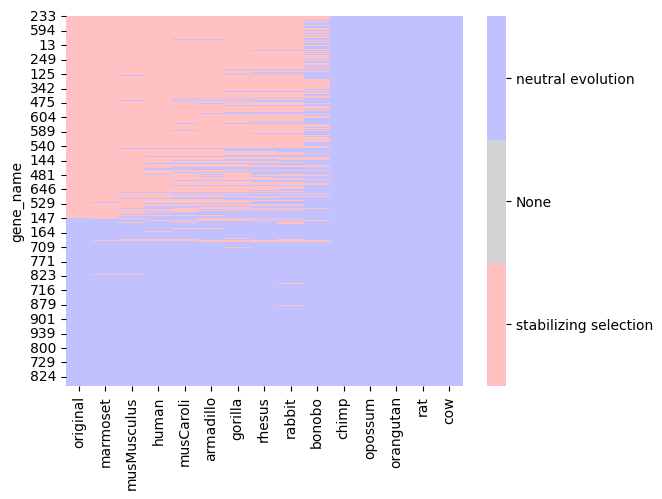

In [19]:
r = RobustTest(original = original, species = species, directory = directory, outpath = outpath)
db = r.heatmap()

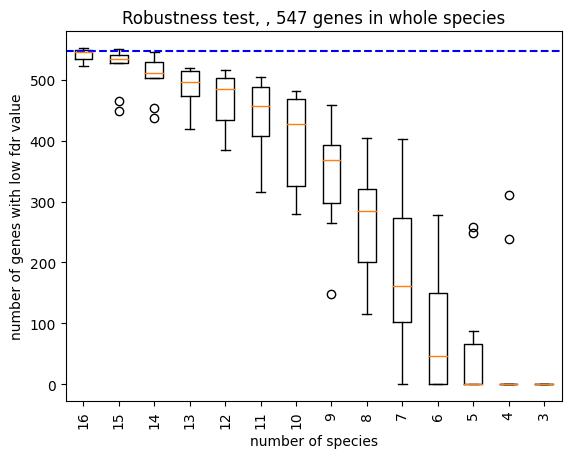

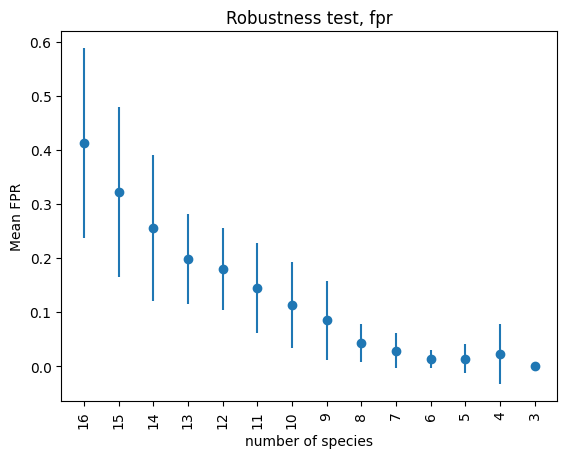

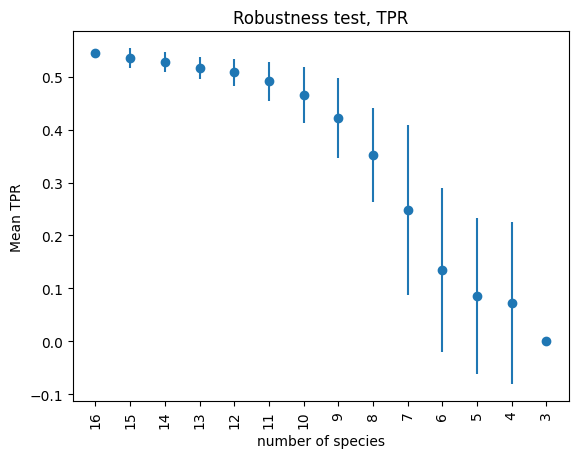

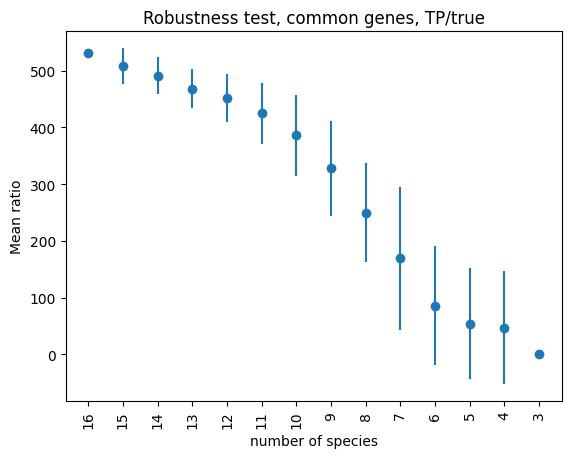

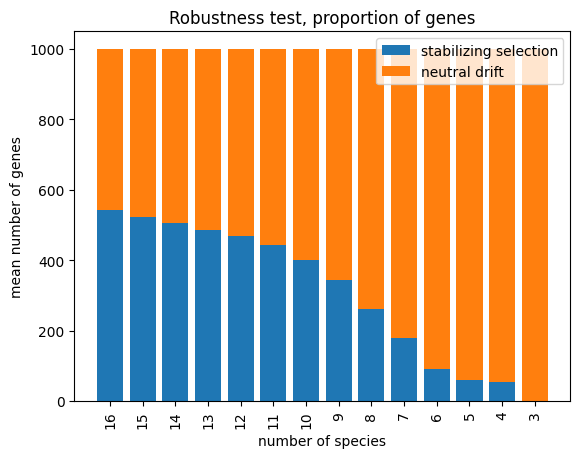

In [20]:
r.plot()